# Generating statistics for subset of Wikidata

This notebook illustrates how to generate statistics for a subset of Wikidata. \
We use as an example https://www.wikidata.org/wiki/Q11173 (chemical compound).

Example Dataset wikidata subset: https://drive.google.com/drive/u/1/folders/1KjNwV5M2G3JzCrPgqk_TSx8wTE49O2Sx \
Example Dataset statistics: https://drive.google.com/drive/u/0/folders/1_4Mxd0MAo0l9aR3aInv0YMTJrtneh7HW 

### Example Invocation command

    papermill /Users/shashanksaurabh/Desktop/MS/ISI/isi/kgtk_shashank73744/kgtk/examples/Example_10_Wikidata_Subgraph_Statistics.ipynb \
    /Users/shashanksaurabh/Desktop/MS/ISI/isi/kgtk_shashank73744/kgtk/examples/Example_10_output.ipynb \
    -p wikidata_home '/Users/shashanksaurabh/Desktop/Data_isi' \
    -p wikidata_parts_folder '/Users/shashanksaurabh/Desktop/Data_isi/Chemical' \
    -p cache_folder '/Users/shashanksaurabh/Desktop/Data_isi/Temp' \
    -p output_folder '/Users/shashanksaurabh/Desktop/Data_isi/output' \
    -p delete_database 'yes' \
    -p K \"10\" \
    -p subset_name 'Q11173'


In [1]:
wikidata_home = "/Volumes/BACKUP/Data_isi"

# path to folder which contains all files corresponding to the wikidata subset. 
#(For more information on wikidata subset please check Example 8)
wikidata_parts_folder = "/Volumes/BACKUP/Data_isi/wikidata/parts"

# The notebook creates a cache, which is present in the cache_folder. The cache can be deleted after the execution.
cache_folder = "/Volumes/BACKUP/Data_isi/wikidata/temp"

# path to the folder where the output (here statistics) would be stored
output_folder = "/Volumes/BACKUP/Data_isi/wikidata/output"

# In each of statistics top K results are chosen.
#In the following examples this has been implemented using the --limit attribute.
K = "5"

# This represents the Qnode of wikidata subset.
subset_name = "Q11173"

In [2]:
import io
import os
import subprocess
import sys
import math

import numpy as np
import pandas as pd

from IPython.display import display, HTML, Markdown, Image

from kgtk.kypher.sqlstore import *

import matplotlib.pyplot as plt

import shutil

from qwikidata.sparql  import return_sparql_query_results

# import altair as alt
# alt.renderers.enable('altair_viewer')

# from IPython.display import display, HTML, Image
# from pandas_profiling import ProfileReport

In [3]:
try:
    int_k = int(K)
except Exception as e:
    int_k = int(K[1:-1])

### Set up environment variables and folders that we need

In [5]:
# path to folder which contains all files corresponding to the wikidata subset. 
#(For more information on wikidata subset please check Example 8)
os.environ['WIKIDATA_PARTS'] = wikidata_parts_folder

# path to the folder where the output (here statistics) would be stored
os.environ['OUTPUT_FOLDER'] = output_folder

# The statistics are stored in two different folders, overview folder and class folder.
# If the folders are not present then in the following command they are created
if not os.path.isdir(os.path.join(output_folder,"overview")):
    os.mkdir(os.path.join(output_folder,"overview"))    
if not os.path.isdir(os.path.join(output_folder,"class_overview")):
    os.mkdir(os.path.join(output_folder,"class_overview"))
if not os.path.isdir(os.path.join(output_folder,"property_overview")):
    os.mkdir(os.path.join(output_folder,"property_overview"))
if not os.path.isdir(os.path.join(output_folder,"raw_files")):
    os.mkdir(os.path.join(output_folder,"raw_files"))
if not os.path.isdir(os.path.join(os.path.join(output_folder,"raw_files"),"overview")):
    os.mkdir(os.path.join(os.path.join(output_folder,"raw_files"),"overview"))
if not os.path.isdir(os.path.join(os.path.join(output_folder,"raw_files"),"class_overview")):
    os.mkdir(os.path.join(os.path.join(output_folder,"raw_files"),"class_overview"))
if not os.path.isdir(os.path.join(os.path.join(output_folder,"raw_files"),"property_overview")):
    os.mkdir(os.path.join(os.path.join(output_folder,"raw_files"),"property_overview"))

# Environmnet variable for the two sub folders where the statistics would be stored  
os.environ['OVERVIEW_FOLDER'] = os.path.join(output_folder,"overview")
os.environ['CLASS_FOLDER'] = os.path.join(output_folder,"class_overview")
os.environ['PROPERTY_OVERVIEW'] = os.path.join(output_folder,"property_overview")
os.environ['RAW_FILES_OVERVIEW'] = os.path.join(os.path.join(output_folder,"raw_files"),"overview")
os.environ['RAW_FILES_PROPERTY'] = os.path.join(os.path.join(output_folder,"raw_files"),"property_overview")
os.environ['RAW_FILES_CLASS'] = os.path.join(os.path.join(output_folder,"raw_files"),"class_overview")

# kgtk command to run
os.environ['kgtk'] = "kgtk"
os.environ['kgtk'] = "time kgtk --debug"

# absolute path of the db
os.environ['STORE'] = "{}/wikidata.sqlite3.db".format(cache_folder)
os.environ['K'] = K
os.environ['label'] = "labels.en.tsv.gz"

# file name corresponding to different part of the Wikidata subgraph.
os.environ['subset_name']  = subset_name
os.environ['external_id']  = "claims.external-id.tsv.gz"
os.environ['time']  =  "claims.time.tsv.gz"
os.environ['wikibase_item']  = "claims.wikibase-item.tsv.gz"
os.environ['quantity']  =  "claims.quantity.tsv.gz"
os.environ['statistics']  =  "claims.statistics.tsv.gz"
os.environ['wikibase_form']  = "claims.wikibase-form.tsv.gz"
os.environ['monolingualtext']  =  "claims.monolingualtext.tsv.gz"
os.environ['math']  =  "claims.math.tsv.gz"
os.environ['commonsMedia']  =  "claims.commonsMedia.tsv.gz"
os.environ['globe_coordinate']  =  "claims.globe-coordinate.tsv.gz"
os.environ['musical_notation']  =  "claims.musical-notation.tsv.gz"
os.environ['geo_shape']  = "claims.geo-shape.tsv.gz"
os.environ['url']  = "claims.url.tsv.gz"
os.environ['string']  = "claims.string.tsv.gz"
os.environ['alias']  = "aliases.en.tsv.gz"
os.environ['description']  = "descriptions.en.tsv.gz"

# file name corresponding to the qualifiers
os.environ['external_id_qualifiers']  = "qualifiers.external-id.tsv.gz"
os.environ['time_qualifiers']  =  "qualifiers.time.tsv.gz"
os.environ['wikibase_item_qualifiers']  = "qualifiers.wikibase-item.tsv.gz"
os.environ['quantity_qualifiers']  =  "qualifiers.quantity.tsv.gz"
os.environ['statistics_qualifiers']  =  "qualifiers.statistics.tsv.gz"
os.environ['wikibase_form_qualifiers']  = "qualifiers.wikibase-form.tsv.gz"
os.environ['monolingualtext_qualifiers']  =  "qualifiers.monolingualtext.tsv.gz"
os.environ['math_qualifiers']  =  "qualifiers.math.tsv.gz"
os.environ['commonsMedia_qualifiers']  =  "qualifiers.commonsMedia.tsv.gz"
os.environ['globe_coordinate_qualifiers']  =  "qualifiers.globe-coordinate.tsv.gz"
os.environ['musical_notation_qualifiers']  =  "qualifiers.musical-notation.tsv.gz"
os.environ['geo_shape_qualifiers']  = "qualifiers.geo-shape.tsv.gz"
os.environ['url_qualifiers']  = "qualifiers.url.tsv.gz"
os.environ['string_qualifiers']  = "qualifiers.string.tsv.gz"


# Output file corresponding to the overview folder (contains overview part of the statistics)
os.environ['class_summary']  = "Overview.class.tsv"
os.environ['top_pagrank']  = "top_pagrank.tsv"
os.environ['stats']  = "Overview.nodes.tsv"
os.environ['all_degree']  = "allDegree.tsv"
os.environ['degree']  = "Overview.degree.tsv"
os.environ['temp']  = "temp_tsv.tsv"
os.environ['magnitudes_destribution'] =  "magnitude_destribution_for_quantity.tsv"
os.environ['year_destribution_per_deacade'] =  "year_destribution_for_time_per_decade.tsv"
os.environ['year_destribution_per_50_years'] =  "year_destribution_for_time_per_50_years.tsv"
os.environ['globe_coordinate_destribution'] =   "coordinate_destribution_for_globe_coordinate.tsv"
os.environ['geo_shape_random_samples'] = "Property_overview.geo_shape.random.tsv"

# Output files corresponding to the class summary folder (contains class summary part of the statistics)
os.environ['property_summary_external_id']  = "Overview.property.externalID.tsv"
os.environ['property_summary_time']  = "Overview.property.time.tsv"
os.environ['property_summary_wikibase_item']  = "Overview.property.wikibaseItem.tsv"
os.environ['property_summary_quantity']  = "Overview.property.quantity.tsv"
os.environ['property_summary_wikibase_form']  = "Overview.property.wikibaseForm.tsv"
os.environ['property_summary_monolingualtext']  = "Overview.property.monolingualText.tsv"
os.environ['property_summary_math']  = "Overview.property.math.tsv"
os.environ['property_summary_commonsMedia']  = "Overview.property.commonsMedia.tsv"
os.environ['property_summary_globe_coordinate']  = "Overview.property.globeCoordinate.tsv"
os.environ['property_summary_musical_notation']  = "Overview.property.musicalNotation.tsv"
os.environ['property_summary_geo_shape']  = "Overview.property.geoShape.tsv"
os.environ['property_summary_url']  = "Overview.property.url.tsv"
os.environ['property_summary_string']  = "Overview.property.strings.tsv"

In [6]:
#Deleting any files in the output folder
# !rm -f $OVERVIEW_FOLDER/*
# !rm -f $CLASS_FOLDER/*
# !rm -f $PROPERTY_OVERVIEW/*

In [7]:
#Variable storing all the datatypes of a properties
types = [ "time",
         "wikibase_item",
         "math",
         "wikibase_form",
         "quantity",
         "string",
         "external_id",
         "commonsMedia",
         "globe_coordinate",
         "monolingualtext",
         "musical_notation",
         "geo_shape",
         "url"
        ]

In [8]:
types_with_fileName = [
        ("time","Time","property_summary_time"),
        ("wikibase_item","Wikibase_item","property_summary_wikibase_item"),
        ("math","Math","property_summary_math"),
        ("wikibase_form","Wikibase-form","property_summary_wikibase_form"),
        ("quantity","Quantity","property_summary_quantity"),
        ("string","String","property_summary_string"),
        ("external_id","External-id","property_summary_external_id"),
        ("commonsMedia","CommonsMedia","property_summary_commonsMedia"),
        ("globe_coordinate","Globe-coordinate","property_summary_globe_coordinate"),
        ("monolingualtext","Monolingualtext","property_summary_monolingualtext"),
        ("musical_notation","Musical-notation","property_summary_musical_notation"),
        ("geo_shape","Geo-shape","property_summary_geo_shape"),
        ("url","Url","property_summary_url"),
    ]

In [9]:
FNULL = open(os.devnull, 'w')
def run_command(cmd, substitution_dictionary = {}):
    """Run a templetized command."""
    debug = False
    for k, v in substitution_dictionary.items():
        cmd = cmd.replace(k, v)
    
    if debug:
        print(cmd)
        output = subprocess.run([cmd], shell=True, universal_newlines=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        print(output.stdout)
        print(output.stderr)
    else:
        output = subprocess.run([cmd], shell=True, universal_newlines=True, stdout=FNULL, stderr=subprocess.PIPE)
    #print(output.returncode)

In [10]:
FNULL = open(os.devnull, 'w')
def run_command_return_df(cmd,folder,output_file, substitution_dictionary = {},save=True,restart=True):
    """Run a templetized command."""
    debug = True
    file_path = os.path.join(os.getenv(folder),output_file)
    # Restart here means if the command has already been run then just read the dataframe from file and return it.
    if restart and os.path.exists(file_path):
        try:
            df = pd.read_csv(file_path,delimiter='\t')
            return df
        except:
            os.remove(file_path)        
    
    #Replace the string with the substitution dictionary
    for k,v in substitution_dictionary.items():
        cmd = cmd.replace(k, v)

    #Based on debug print the statement or not
    if debug:
        print(cmd)
        output = subprocess.run([cmd], shell=True, universal_newlines=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        print(output.stdout)
        print(output.stderr)
    else:
        output = subprocess.run([cmd], shell=True, universal_newlines=True, stdout=FNULL, stderr=subprocess.PIPE)
    
    
    try:
        df = pd.read_csv(file_path,delimiter='\t')
    except Exception as e:
        df = pd.DataFrame()
        
    #If save is set to False then delete the output file.
    if not save:
        if os.path.exists(file_path):
            os.remove(file_path)
    return df
#   print(output.returncode)

In [11]:
# This function is used to print the string in different font, colors and font-size.
def printmd(string,color='black',size='25',fontWeight="bold"):
    colorstr = "<span style='font-weight: {};margin-top=80px;margin-bottom=80px; font-size:{}; color:{}'>{}</span>".format(fontWeight,str(size)+'px',color, string)
    display(HTML(colorstr))

In [12]:
# Its  a helper function which given a qnode or pnode returns the link corresponding to it.
def generate_link(string):
    if string[0] == 'P':
        return "https://www.wikidata.org/wiki/Property:"+string 
    elif string[0] == 'Q':
        return "https://www.wikidata.org/wiki/"+string
    return string

In [13]:
# It returns the label of the qnode
def find_label(qnode):
    try:
        if(str(qnode)=="nan"):
            return "Number"
        query_string = """
                PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> \
                PREFIX wd: <http://www.wikidata.org/entity/> \
                SELECT  * \
                WHERE { \
                    wd:__qnode rdfs:label ?label . \
                    FILTER (langMatches( lang(?label), "EN" ) ) \
                  } \
                LIMIT 1
            """
        query_string = query_string.replace("__qnode",str(qnode))
        res = return_sparql_query_results(query_string)
#         print(query_string)
#         print(res)
        if 'results' in res and "bindings" in res['results'] and len(res['results']['bindings'])>=1 and "label" in res['results']['bindings'][0] and "value" in res['results']['bindings'][0]["label"] :
            return res['results']['bindings'][0]["label"]["value"].capitalize()
        return qnode
    except Exception as e:
        return qnode

In [14]:
def Capitalize(String_item):
    try:
        if type(String_item)=="str":
            return String_item.capitalize()
        else:
            return String_item.to_string().capitalize()
    except Exception as e:
        return String_item

In [15]:
#This function display the top units for the property of datatype:quantity
#@argument
#pnode: The pnode of the property for which the top units and destribution is to be found
#prop_label: The label of the property for which the units and destribution is to be found
#_restart: Here restart means if you allow to use any existing, keep it true if you re running it or you have imported the files.
#_save: If it is set then it will save the file otherwise will delete any generated file.
#folder: The folder in which the output files to be stored
#raw_folder: This work in conjunction with _restart, in this folder all the raw files are stored
def quantity_distribution(pnode,prop_label,_restart=True,_save=True,folder="PROPERTY_OVERVIEW",raw_folder="RAW_FILES_PROPERTY"):
     #This Kypher querry can be used to find the destribution of all the wikidata units for a property
    cmd1 = "$kgtk query -i $WIKIDATA_PARTS/$quantity --graph-cache $STORE \
            -o $__folder/__output_file \
            --match  '(n1)-[r{label:llab}]->(v)' \
            --return 'distinct kgtk_quantity_wd_units(v) as Unit , count(n1) as Number_of_Statements ' \
            --where 'kgtk_quantity(v) AND (llab in [\"__prop\"])' \
            --order-by 'count(n1) desc' "

    #This Kypher querry can be used to find the destribution of all the wikidata units(SI) for a property
    cmd2 = "$kgtk query -i $WIKIDATA_PARTS/$quantity --graph-cache $STORE \
            -o $__folder/__output_file \
            --match  '(n1)-[r{label:llab}]->(v)' \
            --return 'distinct kgtk_quantity_si_units(v) as Unit , count(n1) as Number_of_Statements ' \
            --where 'kgtk_quantity(v) AND (llab in [\"__prop\"])' \
            --order-by 'count(n1) desc' "

    #This Kypher querry can be used to find all the statements corresponding to a unit(Qnode) and a property 
    cmd3 = "$kgtk query -i $WIKIDATA_PARTS/$quantity --graph-cache $STORE \
            -o $__folder/__output_file \
            --match  '(n1)-[r{label:llab}]->(v)' \
            --return 'kgtk_quantity_number(v) as Magnitude ' \
            --where 'kgtk_quantity(v) AND (kgtk_quantity_wd_units(v) in [\"__unit\"]) AND (llab in [\"__prop\"])' "

    #This Kypher querry can be used to find all the statements corresponding to a unit(SI unit) and a property 
    cmd4 = "$kgtk query -i $WIKIDATA_PARTS/$quantity --graph-cache $STORE \
            -o $__folder/__output_file \
            --match  '(n1)-[r{label:llab}]->(v)' \
            --return 'kgtk_quantity_number(v) as Magnitude ' \
            --where 'kgtk_quantity(v) AND (kgtk_quantity_si_units(v) in [\"__unit\"]) AND (llab in [\"__prop\"])' "
    
    #This Kypher querry can be used to find the destribution number when there is no unit but number for a datatype
    cmd5 = "$kgtk query -i $WIKIDATA_PARTS/$quantity --graph-cache $STORE \
            -o $__folder/__output_file \
            --match  '(n1)-[r{label:llab}]->(v)' \
            --return 'kgtk_quantity_number(v) as Magnitude ' \
            --where 'kgtk_number(v) AND (llab in [\"__prop\"])' "


    #Dynamically setting the name of the output file based on the name of property
    output_file_units_destribution = "Property_overview.quantity."+prop_label+".units_distribution.raw.tsv"

    output_file_units_destribution_saving = "Property_overview.quantity."+prop_label+".units_distribution.tsv"

    printmd("Below is the distribution of units for " + prop_label + " in the subgraph",'blue')

    #Running command 1 and loading the dataframe
    pd_unit_destribution = run_command_return_df(cmd1,raw_folder,output_file_units_destribution,{"__output_file":output_file_units_destribution,"__prop":pnode,"__folder":raw_folder},save=_save,restart=_restart);

    #If there are no wikidata units then trying for SI units
    if(len(pd_unit_destribution)==0):
            output_file_units_destribution = "Property_overview.quantity."+prop_label+".units_distribution.si.raw.tsv"
            pd_unit_destribution = run_command_return_df(cmd2,raw_folder,output_file_units_destribution,{"__output_file":output_file_units_destribution,"__prop":pnode,"__folder":raw_folder},save=_save,restart=_restart);
            if(len(pd_unit_destribution)==0):
                printmd('There are no units for this property');
                output_file_magnitude_destribution = "Property_overview.quantity."+prop_label+ ".number.value_distibution.raw.tsv"
                output_file_magnitude_destribution_saving = "Property_overview.quantity."+prop_label+ ".number.value_distibution.tsv"
                
                # Running Command 5 to find the destribution of numbers and loading the output in a dataframe apart from saving it.
                magnitude_distribution = run_command_return_df(cmd5,raw_folder,output_file_magnitude_destribution,{"__output_file":output_file_magnitude_destribution,"__prop":pnode,"__folder":raw_folder},save=_save,restart=_restart);
                if (len(magnitude_distribution)>0):
        #             print(magnitude_distribution)
                    # Binnig the magnitudes for displaying the histogram
                    #This is done to remove the log tails
                    start_histogram = magnitude_distribution.quantile(0.01)['Magnitude']
                    end_histogram = magnitude_distribution.quantile(0.99)['Magnitude']
                    step_size = (end_histogram-start_histogram)/1000

                    #This is done to ensure the tail are included if they are small
                    start_histogram = start_histogram -20*step_size
                    end_histogram = end_histogram + 20*step_size
                    bin_values = np.arange(start=start_histogram, stop=end_histogram, step=step_size)
            #         bin_values = np.arange(start=min(magnitude_distribution['Magnitude']), stop=max(magnitude_distribution['Magnitude']), step=10)


                    #Displaying the histogram
                    printmd('Below is a histogram of distribution of Number for ' + str(prop_label).capitalize() + ' in the subgraph','blue')
                    magnitude_distribution['Magnitude'].hist(bins=bin_values, figsize=[14,6])
                    magnitude_distribution = magnitude_distribution['Magnitude'].value_counts(bins=bin_values, sort=False)

                    plt.xlabel("Magnitude")
                    plt.ylabel("Number of values")
                    plt.show()
                    plt.figure()
                else:
                    printmd('There is some error with unit in the subgraph');
                    return
                magnitude_distribution.to_csv(os.path.join(os.getenv(folder),output_file_magnitude_destribution_saving),sep='\t')
                return
            else:
                cmd_for_value_distribution = cmd4
                pd_unit_destribution_display =pd_unit_destribution.copy()
                pd_unit_destribution_display["Unit"] = pd_unit_destribution_display["Unit"].map(Capitalize)
    else:
        cmd_for_value_distribution = cmd3
        pd_unit_destribution_display =pd_unit_destribution.copy()
        pd_unit_destribution_display["Unit"] = pd_unit_destribution_display["Unit"].map(find_label)


    #Saving the file after mapping qnode with label
    pd_unit_destribution_display.to_csv(os.path.join(os.getenv(folder),output_file_units_destribution_saving),sep='\t')

    #Displaying the destribution of qunatities for a property
    display(HTML(pd_unit_destribution_display[:5].to_html(index=False)))

    #Finding the most prevalent unit
    if len(pd_unit_destribution)>=1:

        #Finding the most prevalent unit
#         print(pd_unit_destribution);
        most_prevalent_unit_qnode = str(pd_unit_destribution.iloc[0]['Unit']);
        most_prevalent_unit_label = re.sub("[^0-9a-zA-Z]+", "_",   str(pd_unit_destribution_display.iloc[0]["Unit"]));
        
        if most_prevalent_unit_qnode == "nan":
            most_prevalent_unit_qnode =""
            most_prevalent_unit_label = "Number"
        
        # Dynamically setting the name of output file corresponding to the magnitude destrbution of most prevalent unit
        output_file_magnitude_destribution = "Property_overview.quantity."+prop_label+ "."+most_prevalent_unit_label+ ".value_distibution.raw.tsv"
        output_file_magnitude_destribution_saving = "Property_overview.quantity."+prop_label+ "."+most_prevalent_unit_label+ ".value_distibution.tsv"

        # Running Command 3/4/5 and loading the output in a dataframe apart from saving it.
        if most_prevalent_unit_label == "Number":
            magnitude_distribution = run_command_return_df(cmd5,raw_folder,output_file_magnitude_destribution,{"__output_file":output_file_magnitude_destribution,"__prop":pnode,"__folder":raw_folder},save=_save,restart=_restart);
        else:
            magnitude_distribution = run_command_return_df(cmd_for_value_distribution,raw_folder,output_file_magnitude_destribution,{"__output_file":output_file_magnitude_destribution,"__prop":pnode,"__unit":most_prevalent_unit_qnode,"__folder":raw_folder},save=_save,restart=_restart);
        if (len(magnitude_distribution)>0):
#             print(magnitude_distribution)
            # Binnig the magnitudes for displaying the histogram
            #This is done to remove the log tails
            start_histogram = magnitude_distribution.quantile(0.01)['Magnitude']
            end_histogram = magnitude_distribution.quantile(0.99)['Magnitude']
            step_size = (end_histogram-start_histogram)/1000

            #This is done to ensure the tail are included if they are small
            start_histogram = start_histogram -20*step_size
            end_histogram = end_histogram + 20*step_size
            bin_values = np.arange(start=start_histogram, stop=end_histogram, step=step_size)
    #         bin_values = np.arange(start=min(magnitude_distribution['Magnitude']), stop=max(magnitude_distribution['Magnitude']), step=10)


            #Displaying the histogram
            printmd('Below is a histogram of distribution of values for unit: "'+most_prevalent_unit_label +'" for ' + prop_label + ' in the subgraph','blue')
            magnitude_distribution['Magnitude'].hist(bins=bin_values, figsize=[14,6])
            magnitude_distribution = magnitude_distribution['Magnitude'].value_counts(bins=bin_values, sort=False)

            plt.xlabel(most_prevalent_unit_label)
            plt.ylabel("Number of values")
            plt.show()
            plt.figure()
        else:
            printmd('There is some error with unit in the subgraph');

        #Saving the file for the display using html
        magnitude_distribution.to_csv(os.path.join(os.getenv(folder),output_file_magnitude_destribution_saving),sep='\t')
        return

In [16]:
#This function displays the stacked histogram for the distribution of instances of the property (property must be of time data type)
#@argument
#pnode: The pnode corresponding to the property
#prop_label: The label for the property
#output_file_time_distribution_raw: It is the file name for saving the output file thus reducing re run time.
#restart: Here restart means if you allow to use any existing, keep it true if you re running it or you have imported the files.
#save: If it is set then it will save the file otherwise will delete any generated file.
#min_year: It is the start year for the histogram
#max_year: It is the end year for the histogram
#folder: It is the environment variable corresponding to the path of the folder.
#number_of_unique_classes: It sets the number of unique classes for the histogram
#@return
#It returns a dataframe corresponding to the histogram in the following format
#Year Class1(Count of instances of Class1) Class2(Count of instances of Class2)
def time_prop_distribution(pnode,prop_label,_save=True,_restart=True,output_file_time_distribution_raw=None,_min_year=1800,_max_year=2100,number_of_unique_classes=5,folder="PROPERTY_OVERVIEW",raw_folder="RAW_FILES_PROPERTY"):
    if _min_year > _max_year:
        printmd("_max_year should be greater than the _min_year",'blue')
        return
    
    cmd = "$kgtk query -i $WIKIDATA_PARTS/$time -i $WIKIDATA_PARTS/$wikibase_item  -i $WIKIDATA_PARTS/$label --graph-cache $STORE \
        -o $__folder/__output_file \
        --match  'time: (n1)-[r{label:llab}]->(v), item:(n1)-[l{label:llab2}]->(class), label:(class)-[:label]->(class_with_label)' \
        --return 'kgtk_date_year(v) as Year, kgtk_lqstring_text(class_with_label) as Class' \
        --where 'kgtk_date(v) AND llab in [\"__prop\"] AND llab2 in [\"P31\"] AND kgtk_lqstring_lang_suffix(class_with_label) = \"en\" AND kgtk_date_precision(v)>8 '"
    
    cmd_without_class = "$kgtk query -i $WIKIDATA_PARTS/$time -i $WIKIDATA_PARTS/$wikibase_item  -i $WIKIDATA_PARTS/$label --graph-cache $STORE \
        -o $__folder/__output_file \
        --match  'time: (n1)-[r{label:llab}]->(v)' \
        --return 'kgtk_date_year(v) as Year' \
        --where 'kgtk_date(v) AND llab in [\"__prop\"] AND kgtk_date_precision(v)>8 '"
    
    prop_label = re.sub("[^0-9a-zA-Z]+", "_",  prop_label) 

    if output_file_time_distribution_raw == None:
        output_file_time_distribution_raw = "Property_overview.time."+prop_label+".year_distibution.raw.tsv"
    
    #Running command 1
    time_distribution = run_command_return_df(cmd,raw_folder,output_file_time_distribution_raw,{"__output_file":output_file_time_distribution_raw,"__prop":pnode,"__folder":raw_folder},save=_save,restart=_restart);
    if(len(time_distribution)>0 and "Class" in time_distribution):
        
#Part-1, This is for saving the statistics to file, we are saving everything irrespect of _min_year and _max_year
        
        #Finding the top five unique classes sorted based on number of statements
        unique_classes = time_distribution["Class"].value_counts().keys()[:number_of_unique_classes]

        #Dataframe for stacked histogram
        time_distribution_stacked = pd.DataFrame();

        #Will be saving the result in different format
        time_distribution_stacked_saving = pd.DataFrame();

        #A local function to find the if a class belong to top five classes.
        def names_not_in_top_five(class_name):
            if(class_name not in unique_classes):
                return True
            return False

        #Creating the a boolean column to see if the class belongs to non of the top five class;
        time_distribution["Other"] = time_distribution["Class"].map(names_not_in_top_five)
        for index, name in enumerate(unique_classes):        

            # Ditribution of year for a property and class are stacked in the dataframe time_distribution_stacked
            time_distribution_class = pd.DataFrame()
            time_distribution_class["Year"] = time_distribution[time_distribution["Class"] == name]["Year"]
            time_distribution_stacked[name.capitalize()] = list(time_distribution_class["Year"]) + (len(time_distribution)-len(time_distribution_class))*[np.nan]

        # Adding count for all other classess
        time_distribution_class = pd.DataFrame()
        time_distribution_class["Year"] = time_distribution[time_distribution["Other"]]["Year"]
        time_distribution_stacked["Others"] = list(time_distribution_class["Year"]) + (len(time_distribution)-len(time_distribution_class))*[np.nan]

        #Applying value count to all the columns
        time_distribution_stacked_saving = time_distribution_stacked.apply(pd.Series.value_counts)
        time_distribution_stacked_saving.rename_axis("Year",inplace=True)
        
        output_file_time_distribution = "Property_overview.time."+prop_label+".year_distibution.tsv"
        time_distribution_stacked_saving.to_csv(os.path.join(os.getenv(folder),output_file_time_distribution),sep="\t")
        
#Part-2, This is for showing the histogram, here we are doing everything with reference to the _min_year and _max_year
        time_distribution_zoomed = pd.DataFrame()
        time_distribution_stacked = pd.DataFrame()
        time_distribution_zoomed = (time_distribution[(time_distribution["Year"]>=int(_min_year)) & (time_distribution["Year"]<=int(_max_year))]).copy()
        #Finding the top five unique classes sorted based on number of statements
        unique_classes = time_distribution_zoomed["Class"].value_counts().keys()[:number_of_unique_classes]
        printmd("Below is stacked histogram for " + prop_label.capitalize() + " binned per year from "+str(_min_year).capitalize() +" to "+str(_max_year).capitalize(),'blue')
        #Dataframe for stacked histogram
        time_distribution_stacked = pd.DataFrame();

        #A local function to find the if a class belong to top five classes.
        def names_not_in_top_five_zoomed(class_name):
            if(class_name not in unique_classes):
                return True
            return False

        #Creating the a boolean column to see if the class belongs to non of the top five class;
        time_distribution_zoomed["Other"] = time_distribution_zoomed["Class"].map(names_not_in_top_five_zoomed)
        for index, name in enumerate(unique_classes):        

            # Ditribution of year for a property and class are stacked in the dataframe time_distribution_stacked
            time_distribution_class = pd.DataFrame()
            time_distribution_class["Year"] = time_distribution_zoomed[time_distribution["Class"] == name]["Year"]
            time_distribution_stacked[name.capitalize()] = list(time_distribution_class["Year"]) + (len(time_distribution_zoomed)-len(time_distribution_class))*[np.nan]

        # Adding count for all other classess
        time_distribution_class = pd.DataFrame()
        time_distribution_class["Year"] = time_distribution_zoomed[time_distribution_zoomed["Other"]]["Year"]
        time_distribution_stacked["Others"] = list(time_distribution_class["Year"]) + (len(time_distribution_zoomed)-len(time_distribution_class))*[np.nan]
    #     time_distribution_class["Year"].value_counts().to_csv(os.path.join(os.getenv('PROPERTY_OVERVIEW'),output_file_time_distribution_class),sep='\t')
        # The smallest year in the dataframe
        min_year = max(_min_year,min(time_distribution["Year"]))

        # The largest year in the dataframe
        max_year = min(_max_year,max(time_distribution["Year"]))


        bin_values = np.arange(start=((min_year-20)//10)*10, stop=((max_year+20)//10)*10, step=1)

        time_distribution_stacked.plot.hist(bins=bin_values, stacked=True,figsize=[14,6])

        plt.show()
        
        time_distribution_stacked_saving = pd.DataFrame()
        #Applying value count to all the columns
        time_distribution_stacked_saving = time_distribution_stacked.apply(pd.Series.value_counts)
        time_distribution_stacked_saving.rename_axis("Year",inplace=True)
        
        output_file_time_distribution = "Property_overview.time."+prop_label+".range.year_distibution.raw.tsv"
        time_distribution_stacked_saving.to_csv(os.path.join(os.getenv(raw_folder),output_file_time_distribution),sep="\t")

    else:
        # Checking if the file is produced with the above "command" then deleting it
        file_path = os.path.join(os.getenv(folder),output_file_time_distribution_raw)
        if os.path.exists(file_path):
            try:
                time_distribution = pd.read_csv(file_path,delimiter="\t")
                if "Class" in time_distribution:
                    os.remove(file_path)
            except Exception as e:
                os.remove(file_path)
                
        printmd("Below is histogram for " + prop_label.capitalize() + " binned per year",'blue')
        #Running cmd_without_class 
        time_distribution = run_command_return_df(cmd_without_class,folder,output_file_time_distribution_raw,{"__output_file":output_file_time_distribution_raw,"__prop":pnode,"__folder":folder},save=_save,restart=_restart);
        if(len(time_distribution)>0):
            # The smallest year in the dataframe
            min_year = _min_year

            # The largest year in the dataframe
            max_year = _max_year


            printmd("Below is a histogram for the distribution of '" + prop_label + "' binned per year from "+ str(_min_year).capitalize() +" to "+str(_max_year).capitalize() ,'blue')

            bin_values = np.arange(start=((min_year-20)//10)*10, stop=((max_year+20)//10)*10, step=1)


            time_distribution['Year'].hist(bins=bin_values, figsize=[14,6])

            plt.show()
            time_distribution_stacked_saving = time_distribution["Year"].value_counts()
            time_distribution_stacked_saving.rename_axis("Year",inplace=True)
            output_file_time_distribution = "Property_overview.time."+prop_label+".year_distibution.tsv"
            time_distribution_stacked_saving.to_csv(os.path.join(os.getenv(folder),output_file_time_distribution),sep="\t")
        else:
            printmd("There is some error with this property")
            time_distribution_stacked_saving = pd.DataFrame(columns=["Year","Count"])
    return time_distribution_stacked_saving

In [17]:
#This function displays the  histogram for the distribution of instances of the property (property must be of time data type)
#@argument
#pnode: The pnode corresponding to the property
#prop_label: The label for the property
#property_type: Datatype of the property
#output_file_time_distribution_raw: It is the file name for saving the output file thus reducing re run time.
#restart: Here restart means if you allow to use any existing, keep it true if you re running it or you have imported the files.
#save: If it is set then it will save the file otherwise will delete any generated file.
#folder: It is the environment variable corresponding to the path of the folder.
def property_distribution(pnode,property_type,prop_label,_save=True,_restart=True,output_file_class_distribution=None,number_of_unique_classes=5,folder="PROPERTY_OVERVIEW",raw_folder="RAW_FILES_PROPERTY"):
    cmd_distribution = "$kgtk query -i $WIKIDATA_PARTS/$__input_file -i $WIKIDATA_PARTS/$wikibase_item  -i $WIKIDATA_PARTS/$label --graph-cache $STORE \
    -o $__folder/__output_file \
    --match  'claims: (n1)-[r{label:llab}]->(v), item:(n1)-[l{label:llab2}]->(class), label:(class)-[:label]->(class_with_label)' \
    --return 'distinct kgtk_lqstring_text(class_with_label) as Class, count(kgtk_lqstring_text(class_with_label)) as Number_of_Instances, class as Qnode' \
    --where 'llab in [\"__prop\"] AND llab2 in [\"P31\"] AND kgtk_lqstring_lang_suffix(class_with_label) = \"en\" ' \
    --order-by 'Number_of_Instances desc' "

    cmd_wikibase_item_distribution = "$kgtk query -i $WIKIDATA_PARTS/$wikibase_item  -i $WIKIDATA_PARTS/$label --graph-cache $STORE \
    -o $__folder/__output_file \
    --match  'item: (n1)-[r{label:llab}]->(v), item:(n1)-[l{label:llab2}]->(class), label:(class)-[:label]->(class_with_label)' \
    --return 'distinct kgtk_lqstring_text(class_with_label) as Class, count(kgtk_lqstring_text(class_with_label)) as Number_of_Instances, class as Qnode ' \
    --where 'llab in [\"__prop\"] AND llab2 in [\"P31\"] AND kgtk_lqstring_lang_suffix(class_with_label) = \"en\" ' \
    --order-by 'Number_of_Instances desc' "

    prop_label = re.sub("[^0-9a-zA-Z]+", "_",  prop_label) 
    property_type = re.sub("[^0-9a-zA-Z]+", "_",  property_type) 

    if output_file_class_distribution == None:
        #Dynamically setting the name of the output file based on the name of property
        output_file_class_distribution= "Property_overview."+property_type+"."+prop_label+".class_distribution.tsv"

    if (property_type.lower().find("wikibase") != -1 and property_type.lower().find("item") != -1  ):
        #Running command for wikibase item
        property_class_distribution = run_command_return_df(cmd_wikibase_item_distribution,folder,output_file_class_distribution,{"__output_file":output_file_class_distribution,"__prop":pnode,"__input_file":property_type,"__folder":folder},save=_save,restart=_restart);
    else:
        #Running command for other data types
        property_class_distribution = run_command_return_df(cmd_distribution,folder,output_file_class_distribution,{"__output_file":output_file_class_distribution,"__prop":pnode,"__input_file":property_type,"__folder":folder},save=_save,restart=_restart);
    printmd("Below is ditribution of " + prop_label.capitalize() + " in different classes",'blue')
    if len(property_class_distribution)>0:

        property_distribution_histogram = pd.DataFrame();

        property_distribution_histogram = property_class_distribution[:number_of_unique_classes]

        if(len(property_class_distribution)>number_of_unique_classes):
            other_classes = sum(property_class_distribution["Number_of_Instances"][5:])
            property_distribution_histogram = property_distribution_histogram.append({"Class":"Other Classes","Number_of_Instances":other_classes,"Qnode":"NA"},ignore_index=True)

        property_distribution_histogram[["Class","Number_of_Instances"]].plot.bar(x="Class")

        plt.show()
    else:
        printmd("The subgraph does not have any infromation about the class of the instances of this property",)


In [18]:
#This function displays the overview of the property
#@argument
#Current_Pnode : The pnode of the property for which the overview is to be found
#Property_label : The property label of the property
#_save: If its true then it saves the generated file
#_restart: If its true then it looks the for the saved the file, if it is present loads instead of running the query again
#output_file_overview: It is the file if provided saves the output in that file otherwise saves output in Property_overview.[Property_label].overview.tsv file
#folder: This corresponds to the environment variable corresponding to the folder in which the file would be stored
def property_overview(Current_Pnode,Property_label,Property_type,_save=True,_restart=True,output_file_overview=None,_min_year=1800,_max_year=2100,number_of_unique_classes=5,folder="PROPERTY_OVERVIEW",raw_folder="RAW_FILES_PROPERTY"):   
    
    Property_label = re.sub("[^0-9a-zA-Z]+", "_", Property_label)
    printmd('Property: '+ Property_label.capitalize(),'blue')
    # Find the list of all the description in English language
    cmd = "$kgtk query -i $WIKIDATA_PARTS/$description --graph-cache $STORE \
            -o $__folder/__output_file \
            --match 'description: (n1:__pnode)-[:description]->(n2)' \
            --return 'kgtk_lqstring_text(n2) as Description_ ' \
            --where 'kgtk_lqstring_lang_suffix(n2) = \"en\"'"
    
    Property_label = re.sub("[^0-9a-zA-Z]+", "_",  Property_label) 

    output_file_for_discription_raw = "Property_overview.description."+Property_label+".raw.tsv";

    df_temp = run_command_return_df(cmd,raw_folder,output_file_for_discription_raw,{"__output_file":output_file_for_discription_raw,"__pnode":Current_Pnode,"__folder":raw_folder},_save,_restart);
    description_array = df_temp["Description_"].values.tolist();
    description_current = "".join(description_array[0] if len(description_array)>=1 else "")


    # Find the list of all the aliases in English language
    cmd = "$kgtk query -i $WIKIDATA_PARTS/$alias --graph-cache $STORE \
        -o $__folder/__output_file \
        --match 'alias: (n1:__qnode)-[:alias]->(n2)' \
        --return 'kgtk_lqstring_text(n2) as Alias' \
        --where 'kgtk_lqstring_lang_suffix(n2) = \"en\"' "

    output_file_for_aliases_raw = "Property_overview.aliases."+Property_label+".raw.tsv";
    df_temp = run_command_return_df(cmd,raw_folder,output_file_for_aliases_raw,{"__output_file":output_file_for_aliases_raw,"__qnode":Current_Pnode,"__folder":raw_folder},_save,_restart)
    aliases_current = ", ".join(df_temp["Alias"].values.tolist())
    
    #Find the number of qualifiers for a property
    cmd = "$kgtk query -i $WIKIDATA_PARTS/$wikibase_item -i $WIKIDATA_PARTS/$wikibase_item_qualifiers --graph-cache $STORE \
        -o $__folder/__output_file \
        --match 'claims: ()-[l{label:llab}]->(), qualifiers: (l)-[lq]->(n2)' \
        --return 'count(n2) as Number_of_Qualifiers' \
        --where 'llab in [\"__prop\"]' "
    
    output_file_for_qualifiers_raw = "Property_overview.number_of_qualifiers."+Property_label+".raw.tsv";
    df_temp_qual = run_command_return_df(cmd,raw_folder,output_file_for_qualifiers_raw,{"__output_file":output_file_for_qualifiers_raw,"__prop":Current_Pnode,"__folder":raw_folder},True,True)
    Number_of_qualifiers = df_temp_qual.loc[0]["Number_of_Qualifiers"]
    
     #Find the number of Statements for a property
    cmd = "$kgtk query -i $WIKIDATA_PARTS/$__input_file --graph-cache $STORE \
        -o $__folder/__output_file \
        --match 'claims: (n1)-[l{label:llab}]->(n2)' \
        --return 'count(llab) as Number_of_Statements' \
        --where 'llab in [\"__prop\"]' "
    
    output_file_for_statements_raw = "Property_overview.number_of_statements."+Property_label+".raw.tsv";
    df_temp_qual = run_command_return_df(cmd,raw_folder,output_file_for_statements_raw,{"__output_file":output_file_for_statements_raw,"__prop":Current_Pnode,"__folder":raw_folder,"__input_file":Property_type},True,True)
    Number_of_statements_of_current_property = df_temp_qual.loc[0]["Number_of_Statements"]
    
    # Print statments
    printmd('Description: '+ description_current.capitalize(),size=15, fontWeight='Light')
    printmd('Aliases: '+ aliases_current.capitalize(),size=15,fontWeight='Light')
    printmd("Number of Statements:  " +str(Number_of_statements_of_current_property),size=15,fontWeight='Light')
    printmd("Number of Qualifiers:  " +str(Number_of_qualifiers),size=15,fontWeight='Light')
    printmd("Property Type: " +str(Property_type),size=15,fontWeight='Light')

    #Create a dataframe corresponding to the above generated statistics
    property_overview = pd.DataFrame([["Description",description_current.capitalize()],["Aliases",aliases_current.capitalize()],["Number of Statements: ",str(Number_of_statements_of_current_property)],["Number of Qualifiers: ",str(Number_of_qualifiers)],["Property Type: ",str(Property_type)]],columns=["Stat","Value"])

    if output_file_overview == None:
        #Dynamically create the name of the output file where the overview would be stored
        output_file_overview ="Property_overview."+Property_label+".overview.tsv" 

    # Save the overview to the output file
    property_overview.to_csv(os.path.join(os.getenv(folder),output_file_overview),sep='\t')
    
    if Property_type.lower().find("time") != -1:
        time_prop_distribution(Current_Pnode,Property_label,_save,_restart,_min_year=_min_year,_max_year=_max_year,number_of_unique_classes=number_of_unique_classes)
    else:
        property_distribution(Current_Pnode,Property_type,Property_label,_save,_restart,number_of_unique_classes=number_of_unique_classes)
        
    if Property_type.lower().find("quantity") != -1:
        quantity_distribution(Current_Pnode,Property_label,_save=_save,_restart=_restart)

    printmd("------------------------------------------------------------------------------------------")

In [19]:
#This is a helper function which extract the qnode/pnode from the link
def get_qnodes_from_link(link):
    return str(link.split("/")[-1])

In [20]:
# Find labels of all the properties of the class
def find_label_property(output_file_labels_property = None, _restart = True,_save=True,folder="RAW_FILES_OVERVIEW"):
    
    if output_file_labels_property == None:
        output_file_labels_property = "Overview.properties.label.raw.tsv"
    file_path = os.path.join(os.getenv(folder),output_file_labels_property)
    
    #Loading the file if it already exists
    if _restart and os.path.exists(file_path):
        try:
            df_label = pd.read_csv(file_path,delimiter='\t')
            return df_label
        except:
            pass
    df_label = pd.DataFrame([],columns=['Property','Label'])
    
    
    #Variable storing all the datatypes of a properties
    types = [ "time",
             "wikibase_item",
             "math",
             "wikibase_form",
             "quantity",
             "string",
             "external_id",
             "commonsMedia",
             "globe_coordinate",
             "monolingualtext",
             "musical_notation",
             "geo_shape",
             "url"
            ]
    
    #Iterating over all the types
    for __type in types:
        #Find label of properties of a Datatype:__type
        __type_label = re.sub("[^0-9a-zA-Z]+", "_", __type)
        cmd = "$kgtk query -i $WIKIDATA_PARTS/$__type -i $WIKIDATA_PARTS/$label --graph-cache $STORE \
        -o $__folder/__output_file \
        --match 'claims: (n1)-[l{label:llab}]->(n2), label: (llab)-[:label]->(n1label)' \
        --return 'distinct llab as Property, n1label as `Label`'"
        
        # Dynamically genrating the output files for each of the labels for a particular property type
        output_file_labels_property_type = "Overview.properties.label."+__type_label+".raw.tsv"
        df_temp = run_command_return_df(cmd,folder,output_file_labels_property_type,{"__output_file":output_file_labels_property_type,"__type":__type,"__folder":folder},True,True)
        df_temp = df_temp.reset_index()
        del df_temp["index"]


        # Dropping if there are many statements for same instances and same property
        # For example a node can have more than P31 statements
        df_temp = df_temp.drop_duplicates()
        df_label = pd.concat([df_label,df_temp])
    df_label.to_csv(os.path.join(os.getenv(folder),output_file_labels_property),sep="\t")
    return df_label

In [21]:
# This is a helper function which finds the statistics on the outcoming properties on the instances of the class
# returns a dataframe object with the statistics
#@parameters
#df_class_example: The dataframe object corresponding to the instances of the class
def find_properties(class_label,df_class_example,df_label,output_class_example_with_index,folder="CLASS_FOLDER",_save=True,_restart=True,raw_folder="RAW_FILES_CLASS"):
    #Instance set is the set of all the qnodes of the instances of the class
    instance_set = set(list(df_class_example["Link"]))
    
    #This is a helper function which finds the percentage corresponding to the passed value
    def find_percent(val):
        return round(val*100/number_of_instances,2)
    
    # This is a helper function which finds the label for the node
    def label_node(node):
        for ele in df_label[df_label['Property']==node]['Label']:
            if kgtk_lqstring_lang_suffix(ele) == "en":
                return kgtk_lqstring_text(ele)
        return node
    
    # Number of distinct qnodes in the example set.
    number_of_instances = len(instance_set)
    
    # Creating the data frame for the output
    df_all_prop = pd.DataFrame([],columns=['id','node1','label','node2'])
    for type_ in types:
        
        cmd = "$kgtk query -i $__folder/__input_file_1 -i $WIKIDATA_PARTS/$__type --graph-cache $STORE \
               -o $__folder/__output_file \
               --match 'example: (n1)-[l1]->(n2), claims:(n1)-[l{label:llab}]->(val)' \
               --return 'n1 as node1, llab as `label` '"
        type_label = re.sub("[^0-9a-zA-Z]+", "_",  type_) 
        
        #Dynamically creating the output file for storing all the statements for all the instances of the class
        output_file_instances_claims_type = "Class_overview."+class_label+"."+type_label+".claims.raw.tsv"
        df_temp = run_command_return_df(cmd,raw_folder,output_file_instances_claims_type,{"__output_file":output_file_instances_claims_type,"__type":type_,"__input_file_1":output_class_example_with_index,"__folder":raw_folder},_save,_restart)
        df_temp = df_temp.reset_index()
        del df_temp["index"]
        
        
        # Dropping if there are many statements for same instances and same property
        # For example a node can have more than P31 statements
        df_temp = df_temp.drop_duplicates()
        df_all_prop = pd.concat([df_all_prop,df_temp])
    df_all_prop = df_all_prop.reset_index()
    
    # Finding the count for each of the properties
    df_all_prop = df_all_prop['label'].value_counts()
    df_all_prop = df_all_prop.reset_index()
    df_all_prop.columns = ["Property Name","Instances"]
    
    # Finding the Percent
    df_all_prop["% Instances"] = df_all_prop["Instances"].map(find_percent)
    df_all_prop["Property Name"] = df_all_prop["Property Name"].map(label_node)

    return df_all_prop

In [22]:
# This is a helper function which finds the statistics on the incoming properties on the instances of the class
# returns a dataframe object with the statistics
#@parameters
#df_class_example: The dataframe object corresponding to the instances of the class
def find_properties_incoming(class_label,df_class_example,df_label,output_class_example_with_index,_save=True,_restart=True,folder="CLASS_FOLDER",raw_folder="RAW_FILES_CLASS"):
#     df_label = pd.read_csv(os.path.join(os.getenv('WIKIDATA_PARTS'),os.getenv('label')),delimiter='\t')

    #Environment variable corresponding to the statistics of each of the property data type
    # Here wikibase_item is only relevant because it only has node2 as wikibase-item.
    types = [
             "wikibase_item"
            ]
    
    # This is a helper function which finds the label for the node
    def label_node(node):
        for ele in df_label[df_label['Property']==node]['Label']:
            if kgtk_lqstring_lang_suffix(ele) == "en":
                return kgtk_lqstring_text(ele)
        return node
            
    # Creating the data frame for the output
    df_all_prop = pd.DataFrame([],columns=['id','node1','label','node2'])
    for type_ in types:
        
        #Command to find all the properties of the instances
        cmd = "$kgtk query -i $__folder/__input_file_1 -i $WIKIDATA_PARTS/$__type --graph-cache $STORE \
               -o $__folder/__output_file \
               --match 'examples: (n1)-[l1]->(n2), claims:(val)-[l{label:llab}]->(n1)' \
               --return 'n1 as node1, llab as `label` '"
        
        type_label = re.sub("[^0-9a-zA-Z]+", "_",  type_) 
        
        #Dynamically Generating output file for saving all the incoming properties to instances of a class
        output_file_incoming_claims_type = "Class_overview."+class_label+"."+type_label+".incoming_claims.raw.tsv"
        df_temp = run_command_return_df(cmd,raw_folder,output_file_incoming_claims_type,{"__output_file":output_file_incoming_claims_type,"__type":type_,"__input_file_1":output_class_example_with_index,"__folder":raw_folder},_save,_restart)
        
        #removing the index from the dataframe
        df_temp = df_temp.reset_index()
        del df_temp["index"]
        
                
        # Dropping if there are many statements for same instances and same property
        # For example a node can have more than P31 statements
        df_temp = df_temp.drop_duplicates()
        df_all_prop = pd.concat([df_all_prop,df_temp])
        
    df_all_prop = df_all_prop.reset_index()
    
    # Finding the count for each of the properties
    df_all_prop = df_all_prop['label'].value_counts()
    df_all_prop = df_all_prop.reset_index()
    df_all_prop.columns = ["Property Name","Instances"]
    df_all_prop["Property Name"] = df_all_prop["Property Name"].map(label_node)

    return df_all_prop

In [23]:
#This function gives the overview of a property 
#@parameter
#Current_Qnode: The qnode corresponding to the class
#class_label: The label corresponding ot the class
#_save: This options saves any intermediate file and work in relation with _restrart
#_restart: This option uses any intermediate file saved during the execution and thus reduce the time of run
#folder: The folder in which the files are saved.
def class_overview(Current_Qnode,class_label,_save=True,_restart=True,number_of_examples=3,number_of_incoming_properties=10,number_of_outgoing_properties=10,folder="CLASS_FOLDER",raw_folder="RAW_FILES_CLASS"):
    # Heading
    printmd('Class: '+class_label,'blue')

    # Find the list of all the description in English language
    cmd = "$kgtk query -i $WIKIDATA_PARTS/$description --graph-cache $STORE \
            -o $__folder/__output_file \
            --match 'descriptions: (n1:__qnode)-[:description]->(n2)' \
            --return 'kgtk_lqstring_text(n2) as Description_ ' \
            --where 'kgtk_lqstring_lang_suffix(n2) = \"en\"'"

    output_file_class_description = "Class_overview.description."+class_label+".raw.tsv"
    df_temp = run_command_return_df(cmd,raw_folder,output_file_class_description,{"__output_file":output_file_class_description,"__qnode":Current_Qnode,"__folder":raw_folder},_save,_restart);
    number_of_description = len(df_temp["Description_"])
    description_array = df_temp["Description_"].values.tolist();
    description_current = description_array[0] if len(description_array)>=1 else ""

    # Find the list of all the aliases in English language
    cmd = "$kgtk query -i $WIKIDATA_PARTS/$alias --graph-cache $STORE \
            -o $__folder/__output_file \
            --match 'alias: (n1:__qnode)-[:alias]->(n2)' \
            --return 'kgtk_lqstring_text(n2) as Alias' \
            --where 'kgtk_lqstring_lang_suffix(n2) = \"en\"' "

    output_file_class_aliases = "Class_overview.aliases."+class_label+".raw.tsv"
    df_temp = run_command_return_df(cmd,raw_folder,output_file_class_aliases,{"__output_file":output_file_class_aliases,"__qnode":Current_Qnode,"__folder":raw_folder},_save,_restart)
    number_of_aliases = len(df_temp["Alias"])
    aliases_current = ", ".join(df_temp["Alias"].values.tolist())

     # Find the list of all the super classes in English language
    cmd = "$kgtk query -i $WIKIDATA_PARTS/$wikibase_item -i $WIKIDATA_PARTS/$label --graph-cache $STORE \
            -o $__folder/__output_file \
            --match 'item: (n1:__qnode)-[l{label:llab}]->(n2), label:(n2)-[:label]->(n2_label)' \
            --return 'distinct kgtk_lqstring_text(n2_label) as Superclass' \
            --where 'kgtk_lqstring_lang_suffix(n2_label) = \"en\" AND llab in [\"P279\"]' "

    output_file_class_super_class = "Class_overview.super_class."+class_label+".raw.tsv"
    df_temp = run_command_return_df(cmd,raw_folder,output_file_class_super_class,{"__output_file":output_file_class_super_class,"__qnode":Current_Qnode,"__folder":raw_folder},_save,_restart)
#     print(df_temp["Superclass"].values.tolist())
    direct_super_class_current = df_temp["Superclass"].values.tolist()

    # Find the list of all the subclasses in English language
    cmd = "$kgtk query -i $WIKIDATA_PARTS/$wikibase_item -i $WIKIDATA_PARTS/$label --graph-cache $STORE \
            -o $__folder/__output_file \
            --match 'item: (n1)-[l{label:llab}]->(n2:__qnode), label:(n1)-[:label]->(n1_label)' \
            --return 'distinct kgtk_lqstring_text(n1_label) as Subclass' \
            --where 'kgtk_lqstring_lang_suffix(n1_label) = \"en\" AND llab in [\"P279\"]' "

    output_file_class_super_class = "Class_overview.subclass_class."+class_label+".raw.tsv"
    df_temp = run_command_return_df(cmd,raw_folder,output_file_class_super_class,{"__output_file":output_file_class_super_class,"__qnode":Current_Qnode,"__folder":raw_folder},_save,_restart)
#     print(df_temp["Subclass"].values.tolist())
    subclass_current = df_temp["Subclass"].values.tolist()

    #Find number of instances of the class
    cmd = "$kgtk query -i $WIKIDATA_PARTS/$wikibase_item --graph-cache $STORE \
            -o $__folder/__output_file \
            --match 'item: (n1)-[l{label:llab}]->(n2:__qnode)' \
            --return 'count(distinct n1) as Number_of_Instances' \
            --where 'llab in [\"P31\"]' "

    output_file_class_number_of_instances = "Class_overview.number_of_instances."+class_label+".raw.tsv"
    df_temp = run_command_return_df(cmd,raw_folder,output_file_class_number_of_instances,{"__output_file":output_file_class_number_of_instances,"__qnode":Current_Qnode,"__folder":raw_folder},_save,_restart)
    Number_of_instances_of_current_class = df_temp["Number_of_Instances"];

    # Print statments
    printmd('Description: '+ description_current.capitalize(),size=15, fontWeight='Light')
    printmd('Aliases: '+ aliases_current.capitalize(),size=15,fontWeight='Light')
    printmd('Direct Superclasses: '+ ", ".join(direct_super_class_current[:10]).capitalize(),size=15,fontWeight='Light')
    printmd('Direct Subclasses: '+ ", ".join(subclass_current[:10]).capitalize(),size=15,fontWeight='Light')
    printmd("Number of Instances: " +str(Number_of_instances_of_current_class),size=15,fontWeight='Light')
    printmd("Number of Superclasses: " +str(len(direct_super_class_current)),size=15,fontWeight='Light')
    printmd("Number of Subclasses: " +str(len(subclass_current)),size=15,fontWeight='Light')
    printmd("Examples for " +class_label +" Class",'black',size=18)

    #Create a dataframe corresponding to the above generated statistics
    class_overview = pd.DataFrame([["Description",description_current.capitalize()],["Aliases",aliases_current.capitalize()],["Subclass of",", ".join(subclass_current).capitalize()],["Number of Instances",Number_of_instances_of_current_class],["Number of Subclass",len(subclass_current)],["Number of Superclass",len(direct_super_class_current)]],columns=["Stat","Value"])

    #Dynamically create the name of the output file where the overview would be stored
    # Save the overview to the output file
    output_file_overview = "Class_overview."+class_label+".overview.tsv"
    class_overview.to_csv(os.path.join(os.getenv(folder),output_file_overview),sep='\t')

    # Find the example instances of the class
    #query to find the example instances of a class
    #Dynamically create the name of the output file where the example instances would be stored
    output_file_examples_temp = "Class_overview."+class_label+".examples.temp.tsv"

    cmd = "$kgtk query -i $WIKIDATA_PARTS/$wikibase_item  -i $WIKIDATA_PARTS/$label -i $WIKIDATA_PARTS/$statistics  --graph-cache $STORE \
            -o $__folder/__output_file \
            --match 'item: (n1)-[l{label:llab}]->(n2:__class), label: (n1)-[:label]->(label), statistics:(:Q42)-[:vertex_pagerank]->(pagerank)' \
            --return ' distinct n1 as Link, kgtk_lqstring_text(label) as `Label_`, pagerank as Pagerank' \
            --where 'label.kgtk_lqstring_lang_suffix = \"en\" AND llab in [\"P31\"]' \
            --order-by 'pagerank' "
    df_class_example = run_command_return_df(cmd,raw_folder,output_file_examples_temp,{"__output_file":output_file_examples_temp,"__class":Current_Qnode,"__folder":raw_folder},_save,_restart)

    #Remove the index from the dataframe
    df_class_example = df_class_example.reset_index()
    del df_class_example["index"]

    #Rename the column names so that it can be used in the kgtk querry
    df_class_example_temp = df_class_example.rename(columns={"Label_":"node2","Pagerank":"label","Link":"node1"})

    #Remove the index from the dataframe
    df_class_example_temp = df_class_example_temp.reset_index()
    del df_class_example_temp['index']
    
    
    #This file is being saved for the GUI
    output_file = "Class_overview."+class_label+".examples.tsv"
    #Saave the file to csv.
    #This is the name of the temporary file which is created with the
    #column names changed to [node1,label,node2] so that we can run kgtk query on it.
    output_file_temp = "temp."+output_file
    df_class_example_temp.to_csv(os.path.join(os.getenv(raw_folder),output_file_temp),sep='\t',index=False)

    # Change the order of the Columns
    df_class_example =  df_class_example[["Label_","Pagerank","Link"]]
    df_class_example['Link'] = df_class_example['Link'].apply(generate_link)
    
    df_class_example.to_csv(os.path.join(os.getenv(folder),output_file),sep='\t')

    display(HTML(df_class_example[:number_of_examples].to_html(index=False)))

    #Add index to the instances of the class
    cmd ="$kgtk add-id -i $__folder/__output_file --id-style node1-label-node2 -o $__folder/__output_class_example_with_index"
    cmd = cmd.replace("__output_file",output_file_temp);
    
    #This is the name of the temporary file which is created with the
    #index added in it.
    output_class_example_with_index = "indexed." + output_file
    cmd = cmd.replace("__output_class_example_with_index",output_class_example_with_index);
    cmd = cmd.replace("__folder",raw_folder);
    run_command(cmd)
    
    #Find labels for all the properties
    df_label = find_label_property()
    
    #Dynamically create the name of the output file where the outgoing properties would be stored
    output_file_prop = "Class_overview."+class_label+".outgoing_properties.tsv"
    df_prop_all = find_properties(class_label,df_class_example,df_label,output_class_example_with_index,_save=_save,_restart=_restart)
    df_prop_all.to_csv(os.path.join(os.getenv(folder),output_file_prop),sep='\t')

    printmd("Distribution of outgoing Properties from instances of " + class_label +" Class",'black',size=18)
    display(HTML(df_prop_all[:number_of_outgoing_properties].to_html(index=False)))

    #Dynamically create the name of the output file where the incoming properties would be stored
    output_file_prop_incoming = "Class_overview."+class_label +".incoming_properties.tsv"
    df_prop_incoming = find_properties_incoming(class_label,df_class_example,df_label,output_class_example_with_index,_save=_save,_restart=_restart)
    df_prop_incoming.to_csv(os.path.join(os.getenv(folder),output_file_prop_incoming),sep='\t')

    printmd("Distribution of incoming Properties to instances of " + class_label +" Class",'black',size=18)
    display(HTML(df_prop_incoming[:number_of_incoming_properties].to_html(index=False)))

    printmd("------------------------------------------------------------------------------------------")
    if os.path.exists(os.path.join(os.getenv(raw_folder),output_file_temp)):
        os.remove(os.path.join(os.getenv(raw_folder),output_file_temp))
    if os.path.exists(os.path.join(os.getenv(raw_folder),output_class_example_with_index)):
        os.remove(os.path.join(os.getenv(raw_folder),output_class_example_with_index))

In [157]:
#Types contain tuple of the environmnet variable corresponding to the input property file, 
#the name of the Datatype and environmnet variable corresponding to the output file.
try:
    number_of_node = 0
    number_of_edges = 0
    number_of_classes = 0
    number_of_properties = 0
    printmd("Overview of the Graph",'blue')

    cmd = "$kgtk query -i $WIKIDATA_PARTS/$wikibase_item --graph-cache $STORE \
    -o $__folder/__output_file \
    --match 'item: (n1)-[l]->(n2)' \
    --return 'count(distinct n1) as number_of_nodes' "

    output_file_number_of_nodes = "Overview.number_of_nodes.raw.tsv"
    df_temp = run_command_return_df(cmd,"RAW_FILES_OVERVIEW",output_file_number_of_nodes,{"__output_file":output_file_number_of_nodes,"__folder":"RAW_FILES_OVERVIEW"},True,True)
    number_of_nodes = df_temp.iloc[0]['number_of_nodes']

    number_of_edges = 0
    # finding the edges for each of the property data type
    for type_,name,file in types_with_fileName:
        cmd = "$kgtk query -i $WIKIDATA_PARTS/$__type --graph-cache $STORE \
        -o $__folder/__output_file \
        --match 'claims: (n1)-[l{label:llab}]->(n2)' \
        --return 'count(llab) as number_of_edges' "
        type_label = re.sub("[^0-9a-zA-Z]+", "_", type_)
        output_file_number_of_edges_type = "Overview.number_of_edges."+type_label+".raw.tsv"
        df_temp = run_command_return_df(cmd,"RAW_FILES_OVERVIEW",output_file_number_of_edges_type,{"__output_file":output_file_number_of_edges_type,"__type":type_,"__folder":"RAW_FILES_OVERVIEW"},True,True)
        if len(df_temp)>0:
            number_of_edges += df_temp.iloc[0]['number_of_edges']

    #Finding the number of classes in the subgraph        
    cmd = "$kgtk query -i $WIKIDATA_PARTS/$wikibase_item --graph-cache $STORE \
    -o $__folder/__output_file \
    --match 'item: (n1)-[l{label:llab}]->(n2)' \
    --where 'llab in [\"P279\"]' \
    --return 'count(distinct n2) as number_of_classes' "

    output_file_number_of_classes = "Overview.number_of_classes.raw.tsv"
    df_temp = run_command_return_df(cmd,"RAW_FILES_OVERVIEW",output_file_number_of_classes,{"__output_file":output_file_number_of_classes,"__folder":"RAW_FILES_OVERVIEW"},True,True)
    number_of_classes = df_temp.iloc[0]['number_of_classes']

    number_of_properties = 0
    #Finding the number of properties in the sub graph
    for type_,name,file in types_with_fileName:
        cmd = "$kgtk query -i $WIKIDATA_PARTS/$__type --graph-cache $STORE \
        -o $__folder/__output_file \
        --match 'claims: (n1)-[l{label:llab}]->(n2)' \
        --return 'count(distinct llab) as number_of_properties' "
        type_label = re.sub("[^0-9a-zA-Z]+", "_", type_)
        output_file_number_of_properties_type = "Overview.number_of_properties."+type_label+".raw.tsv"
        df_temp = run_command_return_df(cmd,"RAW_FILES_OVERVIEW",output_file_number_of_properties_type,{"__output_file":output_file_number_of_properties_type,"__type":type_,"__folder":"RAW_FILES_OVERVIEW"},True,True)
        if len(df_temp)>0:
            number_of_properties += df_temp.iloc[0]['number_of_properties']

    df_stats = pd.DataFrame([["Number of Nodes",number_of_nodes],["Number of Edges",number_of_edges],["Number of Classes",number_of_classes],["Number of Properties",number_of_properties]],columns=['Statistics', 'Value'])
    printmd("Number of Nodes in the Graph: "+str(number_of_nodes),size=15,fontWeight='Light')
    printmd("Number of Edges in the Graph: "+str(number_of_edges),size=15,fontWeight='Light')
    printmd("Number of Classes in the Graph: "+str(number_of_classes),size=15,fontWeight='Light')
    printmd("Number of Properties in the Graph: "+str(number_of_properties),size=15,fontWeight='Light')
    df_stats.to_csv(os.path.join(os.getenv('OVERVIEW_FOLDER'),os.getenv('stats')),sep='\t')
except Exception as e:
    print(e)

In [159]:
# /Volumes/BACKUP/Data_isi/wikidata_/parts/claims.wikibase-item.tsv.gz
try:
#     This query finds the statistics for all the nodes in wikibase_item and save it in a file
    file_path = os.path.join(os.getenv("WIKIDATA_PARTS"),"claims.statistics.tsv.gz")
    if os.path.exists(file_path):
        cmd = "$kgtk query -i $WIKIDATA_PARTS/$wikibase_item -i $WIKIDATA_PARTS/claims.statistics.tsv.gz --graph-cache $STORE \
        -o $__folder/$all_degree \
        --match 'item: (n1)-[l]->(n2), statistics:(n1)-[stats_property{label: llab}]->(stats) ' \
        --return 'distinct n1 as node1, llab as `label`, stats as node2' "
        run_command_return_df(cmd,"RAW_FILES_OVERVIEW",os.getenv('all_degree'),{"__folder":"RAW_FILES_OVERVIEW"},True,True)


        cmd ="$kgtk add-id -i $RAW_FILES_OVERVIEW/$all_degree --id-style node1-label-node2 -o $RAW_FILES_OVERVIEW/all_degree.temp.tsv"
        run_command_return_df(cmd,"RAW_FILES_OVERVIEW","all_degree.temp.tsv",{},True,True)

        cmd = "kgtk --debug query -i $RAW_FILES_OVERVIEW/all_degree.temp.tsv --graph-cache $STORE \
        -o $__folder/__output_file \
        --match 'tsv: (n1)-[l{label:llab}]->(n2)' \
        --where 'llab in [\"vertex_in_degree\"]' \
        --return 'avg(n2) as indegree_avg, min(n2) as indegree_min, max(n2) as indegree_max' "

        output_file_in_degree = "Overview.in_degree.raw.tsv"
        df_temp = run_command_return_df(cmd,"RAW_FILES_OVERVIEW",output_file_in_degree,{"__output_file":output_file_in_degree,"__folder":"RAW_FILES_OVERVIEW"},True,True)
        indegree_avg = df_temp.iloc[0]['indegree_avg']
        indegree_min  = df_temp.iloc[0]['indegree_min']
        indegree_max = df_temp.iloc[0]['indegree_max']

        cmd = "kgtk --debug query -i $RAW_FILES_OVERVIEW/all_degree.temp.tsv --graph-cache $STORE \
        -o $__folder/__output_file \
        --match 'tsv: (n1)-[l{label:llab}]->(n2)' \
        --where 'llab in [\"vertex_out_degree\"]' \
        --return 'avg(n2) as outdegree_avg, min(n2) as outdegree_min, max(n2) as outdegree_max' "


        output_file_out_degree = "Overview.out_degree.raw.tsv"
        df_temp = run_command_return_df(cmd,"RAW_FILES_OVERVIEW",output_file_out_degree,{"__output_file":output_file_out_degree,"__folder":"RAW_FILES_OVERVIEW"},True,True)
        outdegree_avg  = df_temp.iloc[0]['outdegree_avg']
        outdegree_min  = df_temp.iloc[0]['outdegree_min']
        outdegree_max = df_temp.iloc[0]['outdegree_max']
        printmd("Overview of the Graph",'blue')
        if(indegree_avg == 0 or outdegree_avg == 0):
            printmd("There is no information about the degree for this subgraph",size=18)
        else:
            df_degree = pd.DataFrame([["in-degree",indegree_avg,indegree_min,indegree_max],["out-degree",outdegree_avg,outdegree_min,outdegree_max]],columns=["Stat","Average","Min","Max"])
            df_degree.to_csv(os.path.join(os.getenv('OVERVIEW_FOLDER'),os.getenv('degree')),sep='\t')

            printmd("Average in-degree of the Graph: "+str(indegree_avg),size=15,fontWeight='Light')
            printmd("Minimum in-degree of the Graph: "+str(indegree_min),size=15,fontWeight='Light')
            printmd("Maximum in-degree of the Graph: "+str(indegree_max),size=15,fontWeight='Light')
            printmd("Average out-degree of the Graph: "+str(outdegree_avg),size=15,fontWeight='Light')
            printmd("Minimum out-degree of the Graph: "+str(int(outdegree_min)),size=15,fontWeight='Light')
            printmd("Maximum out-degree of the Graph: "+str(int(outdegree_max)),size=15,fontWeight='Light')
    else:
        printmd("There is no information about the degree for this subgraph",size=18)
# if os.path.exists(os.path.join(os.getenv('OVERVIEW_FOLDER'),os.getenv('all_degree'))):
#     os.remove(os.path.join(os.getenv('OVERVIEW_FOLDER'),os.getenv('all_degree')))
# if os.path.exists(os.path.join(os.getenv('OVERVIEW_FOLDER'),"all_degree.temp.tsv")):
#     os.remove(os.path.join(os.getenv('OVERVIEW_FOLDER'),"all_degree.temp.tsv"))
except Exception as e:
    print(e)

In [161]:
try:
    # This query finds all the classes based on number of Instances
    cmd = "$kgtk query -i $WIKIDATA_PARTS/$wikibase_item -i $WIKIDATA_PARTS/$label --graph-cache $STORE \
    -o $__folder/__output_file \
    --match 'item: (n1)-[l{label:llab}]->(n2), label: (n2)-[:label]->(label_n2)' \
    --return 'distinct n2 as Link, kgtk_lqstring_text(label_n2) as `Class_Label`, count(distinct n1) as `Number of Instances`' \
    --where 'label_n2.kgtk_lqstring_lang_suffix = \"en\" AND (llab IN [\"P31\"])  ' \
    --order-by 'count(distinct n1) desc' "

    # Find all the classes in the sub graph
    output_file_temp_class_summary = "temp."+os.getenv('class_summary')
    df_class_summary = run_command_return_df(cmd,"RAW_FILES_CLASS",output_file_temp_class_summary,{"__output_file":output_file_temp_class_summary,"__folder":"RAW_FILES_CLASS"},True,True)

    #The statistics for top K properties are generated and sum of Number of instances for 
    #the remaining properties are stored in other_instances
    other_instances = df_class_summary[int(int_k):]["Number of Instances"].sum()

    #Take top K properties and disregard rest of the properties
    df_class_summary = df_class_summary[:int(int_k)]

    #Take top K properties and disregard rest of the properties
    df_class_summary = df_class_summary[["Class_Label","Number of Instances","Link"]]

    df_class_summary = df_class_summary.append({"Class_Label":"Other Classes","Number of Instances":other_instances,"Link":"NA"},ignore_index=True)

    #Generate hyperlinks from the qnode/pnode
    df_class_summary['Link'] = df_class_summary['Link'].apply(generate_link)

    #Save the dataframe to the output file
    df_class_summary.to_csv(os.path.join(os.getenv('OVERVIEW_FOLDER'),os.getenv('class_summary')),sep='\t')
    printmd("Class Summary of the Subgraph",'blue')
    if(len(df_class_summary)>0):
        printmd("Below is the list of Top K Classes of the Subgraph ordered based on number of instances",size="15",fontWeight="Light")
        display(HTML(df_class_summary.to_html(index=False)))
    else:
        printmd("There is no information about Classes(identified by 'P31') in this graph")
except Exception as e:
    print(e)

Class_Label,Number of Instances,Link
human,8064146,https://www.wikidata.org/wiki/Q5
human settlement,609721,https://www.wikidata.org/wiki/Q486972
village-level division in China,588509,https://www.wikidata.org/wiki/Q13100073
mountain,525197,https://www.wikidata.org/wiki/Q8502
painting,453406,https://www.wikidata.org/wiki/Q3305213
Other Classes,19981095,NA


In [162]:
try:
    df_property_summary = []

    # This query finds all the properties ordered based on Number of Statements
    cmd = "$kgtk query  -i $WIKIDATA_PARTS/$TYPE_FILE -i $WIKIDATA_PARTS/$label --graph-cache $STORE \
    -o $__folder/__output_file \
    --match 'claims: (n1)-[l{label: llab}]->(n2), label: (llab)-[:label]->(label)' \
    --return 'distinct llab as Link, kgtk_lqstring_text(label) as `Property_Label`, count(llab) as `Number_of_Statements`' \
    --where 'label.kgtk_lqstring_lang_suffix = \"en\" ' \
    --order-by 'count(llab) desc '"
    
    # Do it for all the Datatypes
    for type,name, output_file in types_with_fileName:
        output_file_temp = "temp."+os.getenv(output_file)
        temp = run_command_return_df(cmd,"RAW_FILES_PROPERTY",output_file_temp,{"TYPE_FILE": type,"__output_file":output_file_temp,"__folder":"RAW_FILES_PROPERTY"},True,True)
        
        #The statistics for top K properties are generated and sum of Number of statements for 
        #the remaining properties are stored in other_instances
        other_instances = temp[int(int_k):]["Number_of_Statements"].sum()
        
        #Take top K properties and disregard rest of the properties
        temp = temp[:int(int_k)]
        
        #Generated hyperlinks from the qnode/pnode
        temp['Link'] = temp['Link'].apply(generate_link)
        
        #Changing the order of the columns
        temp = temp[["Property_Label","Number_of_Statements","Link"]]
        
        temp = temp.append({"Property_Label":"Other Properties","Number_of_Statements":other_instances,"Link":"NA"},ignore_index=True)
        
        # Storing the temp to output file
        temp.to_csv(os.path.join(os.getenv('OVERVIEW_FOLDER'),os.getenv(output_file)),sep='\t')
        
        # The output if there are no properties for a Datatype
        if len(temp) == 1:
            printmd("Datatype: "+name, 'blue')
            printmd("No Property is present for Datatype:" + name,size=15, fontWeight='Light')
            printmd("------------------------------------------------------------------------------------------")
            continue
        printmd("Datatype: "+name, 'blue')
        printmd("Below are the top K properties of Datatype:" + name +"  ordered based on number of statements",size =15,fontWeight='Light')
        df_property_summary.append(temp)
        if len(df_property_summary[-1])>0:
            display(HTML(df_property_summary[-1].to_html(index=False)))
        else:
            printmd("There are no properties for this datatype or there are no label for the properties of this datatype")
        printmd("------------------------------------------------------------------------------------------")
except Exception as e:
    print(e)

Property_Label,Number_of_Statements,Link
date of birth,4720552,https://www.wikidata.org/wiki/Property:P569
date of death,2350886,https://www.wikidata.org/wiki/Property:P570
inception,2012751,https://www.wikidata.org/wiki/Property:P571
publication date,1732078,https://www.wikidata.org/wiki/Property:P577
point in time,770868,https://www.wikidata.org/wiki/Property:P585
Other Properties,2023280,NA


Property_Label,Number_of_Statements,Link
instance of,30304425,https://www.wikidata.org/wiki/Property:P31
country,12699109,https://www.wikidata.org/wiki/Property:P17
located in the administrative territorial entity,9865374,https://www.wikidata.org/wiki/Property:P131
occupation,6564120,https://www.wikidata.org/wiki/Property:P106
sex or gender,6415611,https://www.wikidata.org/wiki/Property:P21
Other Properties,76771225,NA


Property_Label,Number_of_Statements,Link
defining formula,4573,https://www.wikidata.org/wiki/Property:P2534
Alexander polynomial,2982,https://www.wikidata.org/wiki/Property:P5350
Conway polynomial,2981,https://www.wikidata.org/wiki/Property:P5351
Jones polynomial,2981,https://www.wikidata.org/wiki/Property:P5352
Dowker-Thistlethwaite notation,2978,https://www.wikidata.org/wiki/Property:P8378
Other Properties,2374,NA


Property_Label,Number_of_Statements,Link
generational suffix,502,https://www.wikidata.org/wiki/Property:P8017
Wikidata property example for forms,5,https://www.wikidata.org/wiki/Property:P5193
Other Properties,0,NA


Property_Label,Number_of_Statements,Link
Elo rating,2338336,https://www.wikidata.org/wiki/Property:P1087
elevation above sea level,1706335,https://www.wikidata.org/wiki/Property:P2044
population,1532393,https://www.wikidata.org/wiki/Property:P1082
right ascension,1212968,https://www.wikidata.org/wiki/Property:P6257
declination,1212941,https://www.wikidata.org/wiki/Property:P6258
Other Properties,8244207,NA


Property_Label,Number_of_Statements,Link
catalog code,2528723,https://www.wikidata.org/wiki/Property:P528
Commons category,2107498,https://www.wikidata.org/wiki/Property:P373
postal code,1647175,https://www.wikidata.org/wiki/Property:P281
inventory number,894123,https://www.wikidata.org/wiki/Property:P217
author name string,276478,https://www.wikidata.org/wiki/Property:P2093
Other Properties,3168081,NA


Property_Label,Number_of_Statements,Link
GeoNames ID,3690086,https://www.wikidata.org/wiki/Property:P1566
VIAF ID,2550640,https://www.wikidata.org/wiki/Property:P214
WorldCat Identities ID,1800838,https://www.wikidata.org/wiki/Property:P7859
ORCID iD,1566234,https://www.wikidata.org/wiki/Property:P496
GNS Unique Feature ID,1465898,https://www.wikidata.org/wiki/Property:P2326
Other Properties,38416335,NA


Property_Label,Number_of_Statements,Link
image,3183900,https://www.wikidata.org/wiki/Property:P18
locator map image,200470,https://www.wikidata.org/wiki/Property:P242
coat of arms image,121781,https://www.wikidata.org/wiki/Property:P94
logo image,83035,https://www.wikidata.org/wiki/Property:P154
flag image,41224,https://www.wikidata.org/wiki/Property:P41
Other Properties,263778,NA


Property_Label,Number_of_Statements,Link
coordinate location,8063369,https://www.wikidata.org/wiki/Property:P625
coordinates of northernmost point,9892,https://www.wikidata.org/wiki/Property:P1332
coordinates of westernmost point,9848,https://www.wikidata.org/wiki/Property:P1335
coordinates of easternmost point,9847,https://www.wikidata.org/wiki/Property:P1334
coordinates of southernmost point,9829,https://www.wikidata.org/wiki/Property:P1333
Other Properties,2324,NA


Property_Label,Number_of_Statements,Link
title,2618637,https://www.wikidata.org/wiki/Property:P1476
official name,1184598,https://www.wikidata.org/wiki/Property:P1448
street address,1050341,https://www.wikidata.org/wiki/Property:P6375
native label,513963,https://www.wikidata.org/wiki/Property:P1705
name in native language,499926,https://www.wikidata.org/wiki/Property:P1559
Other Properties,576139,NA


Property_Label,Number_of_Statements,Link
LilyPond notation,695,https://www.wikidata.org/wiki/Property:P6883
ascending scale,78,https://www.wikidata.org/wiki/Property:P7598
descending scale,78,https://www.wikidata.org/wiki/Property:P7599
musical motif,26,https://www.wikidata.org/wiki/Property:P6686
musical quotation or excerpt,6,https://www.wikidata.org/wiki/Property:P6670
Other Properties,0,NA


Property_Label,Number_of_Statements,Link
geoshape,22585,https://www.wikidata.org/wiki/Property:P3896
Other Properties,0,NA


Property_Label,Number_of_Statements,Link
official website,1185776,https://www.wikidata.org/wiki/Property:P856
described at URL,590279,https://www.wikidata.org/wiki/Property:P973
full work available at URL,453000,https://www.wikidata.org/wiki/Property:P953
exact match,231208,https://www.wikidata.org/wiki/Property:P2888
IIIF manifest,164424,https://www.wikidata.org/wiki/Property:P6108
Other Properties,257826,NA


In [51]:
#This is a helper function which extract the qnode/pnode from the link
def get_qnodes_from_link(link):
    return str(link.split("/")[-1])

In [163]:

try:
    printmd('Class Overview','blue')
    # Load the list of classes generated in the  9th cell
    df = pd.read_csv(os.path.join(os.getenv('OVERVIEW_FOLDER'),os.getenv('class_summary')),delimiter='\t')

    df_label = find_label_property()

    # Do for all the classes generated in the 9th cell
    for index, ele in df.iterrows():
        
        # Ignore the Other Classes part of the statistics
        if index==len(df)-1:
            continue;
        # Parse the Qnode from the  Link
        Current_Qnode = ele["Link"].split("/")[-1]

        class_label = re.sub("[^0-9a-zA-Z]+", "_", ele["Class_Label"])

        try:
            Number_of_instances_of_current_class = ele["Number of Instances"]
            class_overview(Current_Qnode,class_label,_restart=True)
        except Exception as e:
            printmd('There is some error while finding the overview of the Class:'+class_label.capitalize())
            display(e)
except Exception as e:
    display(e)

Label_,Pagerank,Link
Tatyana Kolotilshchikova,1.043620e-07,https://www.wikidata.org/wiki/Q10000001
Claus Hammel,1.043620e-07,https://www.wikidata.org/wiki/Q1000002
Karel Matěj Čapek-Chod,1.043620e-07,https://www.wikidata.org/wiki/Q1000005


Property Name,Instances,% Instances
instance of,7306512,100.00
sex or gender,5718320,78.26
occupation,4279155,58.57
date of birth,4086288,55.93
given name,3927872,53.76
country of citizenship,3170984,43.40
place of birth,2345248,32.10
family name,2276615,31.16
date of death,2049407,28.05
VIAF ID,1979198,27.09


Property Name,Instances
child,788083
father,419674
mother,209280
spouse,206045
cast member,163632
sibling,123448
main subject,123239
author,106682
creator,72964
participant,62154


Label_,Pagerank,Link
Wikidata property example for media,1.043620e-07,https://www.wikidata.org/wiki/Property:P6685
Fūren,1.043620e-07,https://www.wikidata.org/wiki/Q1000062
Kitahiyama,1.043620e-07,https://www.wikidata.org/wiki/Q1000066


Property Name,Instances,% Instances
instance of,229477,100.00
country,224789,97.96
coordinate location,202999,88.46
located in the administrative territorial entity,168821,73.57
GeoNames ID,145606,63.45
Who\\'s on First ID,140011,61.01
located in time zone,105599,46.02
elevation above sea level,63879,27.84
Freebase ID,28816,12.56
image,25034,10.91


Property Name,Instances
place of birth,18563
located in the administrative territorial entity,9617
location,8694
capital,7035
place of death,5832
different from,2486
contains settlement,2365
headquarters location,2018
named after,1934
contains administrative territorial entity,1767


Label_,Pagerank,Link
Liqian,1.043620e-07,https://www.wikidata.org/wiki/Q1012794
Xujiawan,1.043620e-07,https://www.wikidata.org/wiki/Q10296348
Xuzhuang,1.043620e-07,https://www.wikidata.org/wiki/Q10296366


Property Name,Instances,% Instances
instance of,8729,100.00
country,8726,99.97
located in the administrative territorial entity,8722,99.92
official name,8643,99.01
located in time zone,8643,99.01
China administrative division code,8640,98.98
coordinate location,217,2.49
image,85,0.97
Commons category,66,0.76
GeoNames ID,42,0.48


Property Name,Instances
contains administrative territorial entity,8701
located in the administrative territorial entity,270
place of birth,11
different from,6
location,6
has part,5
headquarters location,5
named after,3
place of death,2
shares border with,2


Label_,Pagerank,Link
Schützeberg,1.043620e-07,https://www.wikidata.org/wiki/Q1000564
Reither Spitze,1.043620e-07,https://www.wikidata.org/wiki/Q1000705
Rozluch,1.043620e-07,https://www.wikidata.org/wiki/Q10019995


Property Name,Instances,% Instances
instance of,440517,100.00
coordinate location,437277,99.26
country,433456,98.40
GeoNames ID,418283,94.95
located in the administrative territorial entity,343333,77.94
elevation above sea level,292459,66.39
GNS Unique Feature ID,268206,60.88
GNIS ID,60928,13.83
continent,28533,6.48
mountain range,26493,6.01


Property Name,Instances
highest point,2513
named after,1050
parent peak,963
different from,960
located on terrain feature,833
location,552
has part,398
place of death,396
origin of the watercourse,377
part of,343


Label_,Pagerank,Link
The Bohemian,1.043620e-07,https://www.wikidata.org/wiki/Q1000128
Count Lepic and His Daughters,1.043620e-07,https://www.wikidata.org/wiki/Q1016012
Evening Mood,1.043620e-07,https://www.wikidata.org/wiki/Q1022046


Property Name,Instances,% Instances
instance of,278634,100.00
collection,273761,98.25
creator,264007,94.75
location,258997,92.95
inventory number,256177,91.94
inception,220977,79.31
height,178123,63.93
width,178121,63.93
described at URL,164891,59.18
material used,160190,57.49


Property Name,Instances
notable work,6456
has part,2275
pendant of,1410
owner of,1126
based on,989
different from,976
depicted by,674
derivative work,670
depicts,445
followed by,259


In [164]:
try:    
    printmd('Property Overview','blue')
    
    # List of all the datatypes for the property and their tile.
    types_with_titles = [
            ("property_summary_time","time"),
            ("property_summary_wikibase_item", "wikibase_item"),
            ("property_summary_math","math"),
            ("property_summary_wikibase_form", "wikibase_form"),
            ("property_summary_quantity", "quantity"),
            ("property_summary_string", "string"),
            ("property_summary_external_id","external_id"),
            ("property_summary_commonsMedia","commonsMedia"),
            ("property_summary_globe_coordinate", "globe_coordinate"),
            ("property_summary_monolingualtext","monolingualtext"),
            ("property_summary_musical_notation", "musical_notation"),
            ("property_summary_geo_shape", "geo_shape"),
            ("property_summary_url",  "url")
        ]
    
    # Create a new Dataframe to store the result.
    df_all_prop = pd.DataFrame([],columns=["Property_Label","Number_of_Statements","Link"])
    
    # For all types of the properties
    for type_, type_name in types_with_titles:
        
        # Read the file generated above while calculating the statistics
        df_temp = pd.read_csv(os.path.join(os.getenv('OVERVIEW_FOLDER'),os.getenv(type_)),delimiter='\t')
        
        # Adding the column for the data type
        df_temp["Property Type"] = type_name
        
        # Concatenating the data frame
        df_all_prop = pd.concat([df_all_prop,df_temp])
        df_all_prop = df_all_prop.sort_values("Number_of_Statements",ascending=False).reset_index()
        del df_all_prop['index']
        del df_all_prop["Unnamed: 0"]
    
    # Removing the "Other Properties row" which was calculated earlier in the overview section
    df_all_prop = df_all_prop[df_all_prop["Property_Label"]!="Other Properties"]
    printmd("Top Ten Properties are ",'black',size=18)
    display(HTML(df_all_prop[:10].to_html(index=False)))
    df_all_prop.to_csv(os.path.join(os.getenv('PROPERTY_OVERVIEW'),"Property_overview.top.tsv"),sep='\t')
except Exception as e:
    display(e)

Property_Label,Number_of_Statements,Link,Property Type
instance of,30304425,https://www.wikidata.org/wiki/Property:P31,wikibase_item
country,12699109,https://www.wikidata.org/wiki/Property:P17,wikibase_item
located in the administrative territorial entity,9865374,https://www.wikidata.org/wiki/Property:P131,wikibase_item
coordinate location,8063369,https://www.wikidata.org/wiki/Property:P625,globe_coordinate
occupation,6564120,https://www.wikidata.org/wiki/Property:P106,wikibase_item
sex or gender,6415611,https://www.wikidata.org/wiki/Property:P21,wikibase_item
date of birth,4720552,https://www.wikidata.org/wiki/Property:P569,time
GeoNames ID,3690086,https://www.wikidata.org/wiki/Property:P1566,external_id
image,3183900,https://www.wikidata.org/wiki/Property:P18,commonsMedia
title,2618637,https://www.wikidata.org/wiki/Property:P1476,monolingualtext


$kgtk query -i $WIKIDATA_PARTS/$wikibase_item  -i $WIKIDATA_PARTS/$label --graph-cache $STORE     -o $PROPERTY_OVERVIEW/Property_overview.wikibase_item.instance_of.class_distribution.tsv     --match  'item: (n1)-[r{label:llab}]->(v), item:(n1)-[l{label:llab2}]->(class), label:(class)-[:label]->(class_with_label)'     --return 'distinct kgtk_lqstring_text(class_with_label) as Class, count(kgtk_lqstring_text(class_with_label)) as Number_of_Instances, class as Qnode '     --where 'llab in ["P31"] AND llab2 in ["P31"] AND kgtk_lqstring_lang_suffix(class_with_label) = "en" '     --order-by 'Number_of_Instances desc' 

[2021-01-03 04:18:15 query]: SQL Translation:
---------------------------------------------
  SELECT DISTINCT kgtk_lqstring_text(graph_35_c3."node2") "Class", count(kgtk_lqstring_text(graph_35_c3."node2")) "Number_of_Instances", graph_35_c3."node1" "Qnode"
     FROM graph_20 AS graph_20_c1, graph_20 AS graph_20_c2, graph_35 AS graph_35_c3
     WHERE graph_20_c1."label"=graph_2

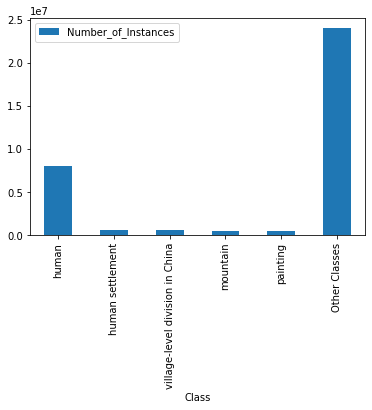

$kgtk query -i $WIKIDATA_PARTS/$wikibase_item  -i $WIKIDATA_PARTS/$label --graph-cache $STORE     -o $PROPERTY_OVERVIEW/Property_overview.wikibase_item.country.class_distribution.tsv     --match  'item: (n1)-[r{label:llab}]->(v), item:(n1)-[l{label:llab2}]->(class), label:(class)-[:label]->(class_with_label)'     --return 'distinct kgtk_lqstring_text(class_with_label) as Class, count(kgtk_lqstring_text(class_with_label)) as Number_of_Instances, class as Qnode '     --where 'llab in ["P17"] AND llab2 in ["P31"] AND kgtk_lqstring_lang_suffix(class_with_label) = "en" '     --order-by 'Number_of_Instances desc' 

[2021-01-03 05:14:00 query]: SQL Translation:
---------------------------------------------
  SELECT DISTINCT kgtk_lqstring_text(graph_35_c3."node2") "Class", count(kgtk_lqstring_text(graph_35_c3."node2")) "Number_of_Instances", graph_20_c2."node2" "Qnode"
     FROM graph_20 AS graph_20_c1, graph_20 AS graph_20_c2, graph_35 AS graph_35_c3
     WHERE graph_20_c1."label"=graph_20_c1

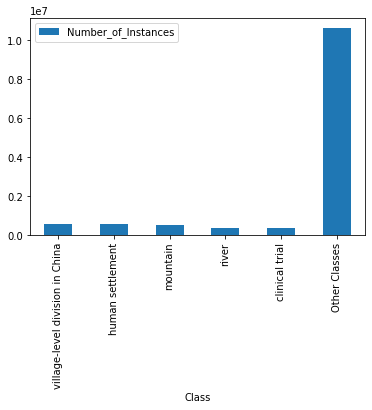

$kgtk query -i $WIKIDATA_PARTS/$wikibase_item  -i $WIKIDATA_PARTS/$label --graph-cache $STORE     -o $PROPERTY_OVERVIEW/Property_overview.wikibase_item.located_in_the_administrative_territorial_entity.class_distribution.tsv     --match  'item: (n1)-[r{label:llab}]->(v), item:(n1)-[l{label:llab2}]->(class), label:(class)-[:label]->(class_with_label)'     --return 'distinct kgtk_lqstring_text(class_with_label) as Class, count(kgtk_lqstring_text(class_with_label)) as Number_of_Instances, class as Qnode '     --where 'llab in ["P131"] AND llab2 in ["P31"] AND kgtk_lqstring_lang_suffix(class_with_label) = "en" '     --order-by 'Number_of_Instances desc' 

[2021-01-03 06:04:35 query]: SQL Translation:
---------------------------------------------
  SELECT DISTINCT kgtk_lqstring_text(graph_35_c3."node2") "Class", count(kgtk_lqstring_text(graph_35_c3."node2")) "Number_of_Instances", graph_20_c2."node2" "Qnode"
     FROM graph_20 AS graph_20_c1, graph_20 AS graph_20_c2, graph_35 AS graph_35_c3


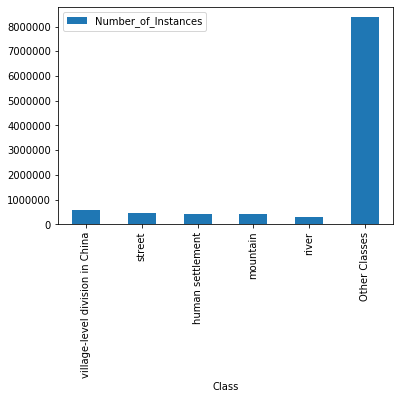

$kgtk query -i $WIKIDATA_PARTS/$globe_coordinate -i $WIKIDATA_PARTS/$wikibase_item  -i $WIKIDATA_PARTS/$label --graph-cache $STORE     -o $PROPERTY_OVERVIEW/Property_overview.globe_coordinate.coordinate_location.class_distribution.tsv     --match  'claims: (n1)-[r{label:llab}]->(v), item:(n1)-[l{label:llab2}]->(class), label:(class)-[:label]->(class_with_label)'     --return 'distinct kgtk_lqstring_text(class_with_label) as Class, count(kgtk_lqstring_text(class_with_label)) as Number_of_Instances, class as Qnode'     --where 'llab in ["P625"] AND llab2 in ["P31"] AND kgtk_lqstring_lang_suffix(class_with_label) = "en" '     --order-by 'Number_of_Instances desc' 

[2021-01-03 06:54:47 query]: SQL Translation:
---------------------------------------------
  SELECT DISTINCT kgtk_lqstring_text(graph_35_c3."node2") "Class", count(kgtk_lqstring_text(graph_35_c3."node2")) "Number_of_Instances", graph_20_c2."node2" "Qnode"
     FROM graph_20 AS graph_20_c2, graph_28 AS graph_28_c1, graph_35 AS 

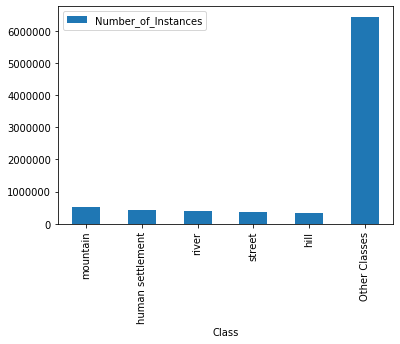

$kgtk query -i $WIKIDATA_PARTS/$wikibase_item  -i $WIKIDATA_PARTS/$label --graph-cache $STORE     -o $PROPERTY_OVERVIEW/Property_overview.wikibase_item.occupation.class_distribution.tsv     --match  'item: (n1)-[r{label:llab}]->(v), item:(n1)-[l{label:llab2}]->(class), label:(class)-[:label]->(class_with_label)'     --return 'distinct kgtk_lqstring_text(class_with_label) as Class, count(kgtk_lqstring_text(class_with_label)) as Number_of_Instances, class as Qnode '     --where 'llab in ["P106"] AND llab2 in ["P31"] AND kgtk_lqstring_lang_suffix(class_with_label) = "en" '     --order-by 'Number_of_Instances desc' 

[2021-01-03 07:43:56 query]: SQL Translation:
---------------------------------------------
  SELECT DISTINCT kgtk_lqstring_text(graph_35_c3."node2") "Class", count(kgtk_lqstring_text(graph_35_c3."node2")) "Number_of_Instances", graph_35_c3."node1" "Qnode"
     FROM graph_20 AS graph_20_c1, graph_20 AS graph_20_c2, graph_35 AS graph_35_c3
     WHERE graph_20_c1."label"=graph_2

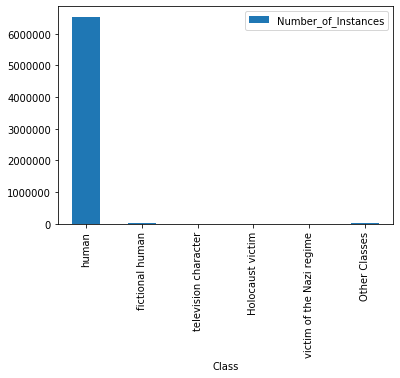

In [165]:
try:    
    # Load the list of classes generated in the  9th cell
    df = pd.read_csv(os.path.join(os.getenv('PROPERTY_OVERVIEW'),"Property_overview.top.tsv"),delimiter='\t')

    # Do for all the classes generated in the 9th cell
    for index, ele in df.iterrows():

        if index>=5:
            break;

        Current_Pnode = ele['Link'].split('/')[-1].split(":")[-1]
        Number_of_statements_of_current_property = ele["Number_of_Statements"]
        Property_type = ele["Property Type"]
        Property_label = re.sub("[^0-9a-zA-Z]+", "_", ele["Property_Label"])

        # Heading
        try:
            property_overview(Current_Pnode,Property_label,Property_type,True,True)
        except Exception as e:
            printmd("There some problem finding the overview of the Property:"+Property_label.capitalize())
except Exception as e:
    display(e)

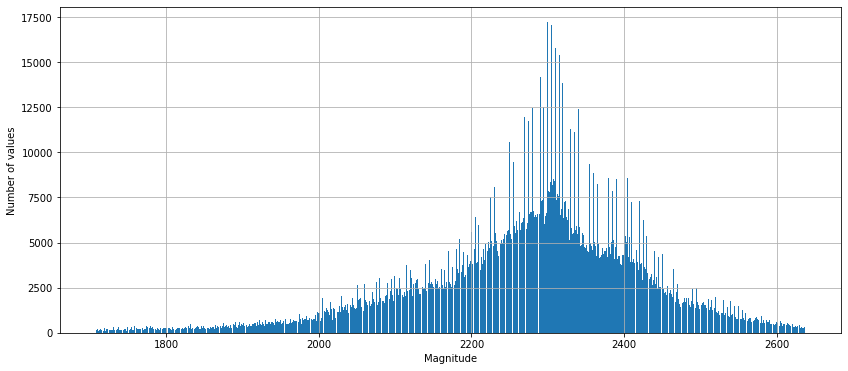

Unit,Number_of_Statements
Metre,1648955
Foot,57175
Height above mean sea level,20
Kilometre,19
Sea level,9


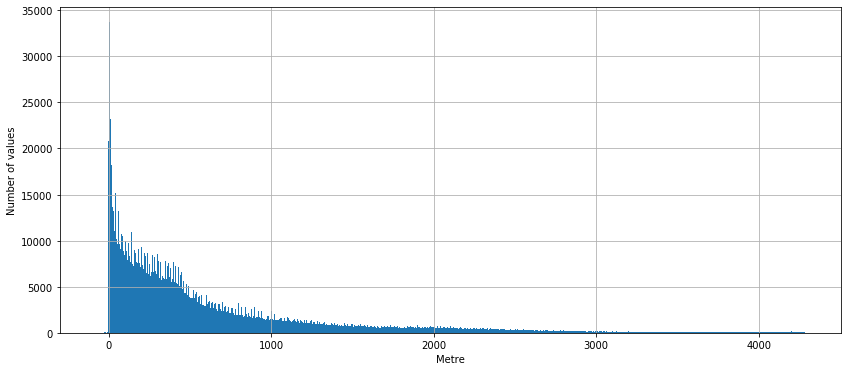

Unit,Number_of_Statements
Number,2117
Q12248389,101
2018,19
Habitants,16
Q1621322,9


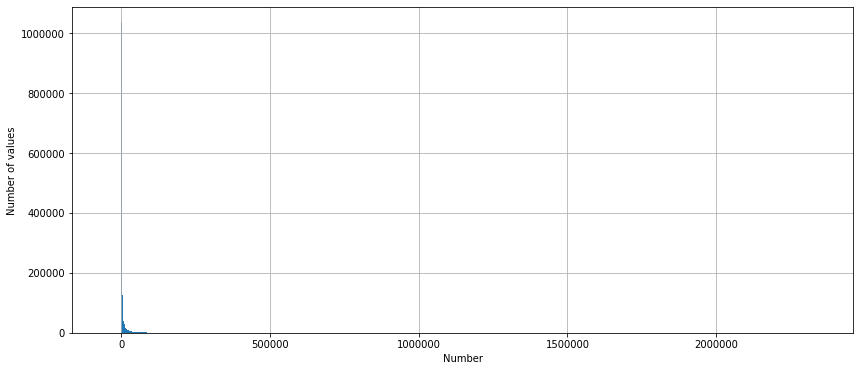

Unit,Number_of_Statements
Degree,1212968


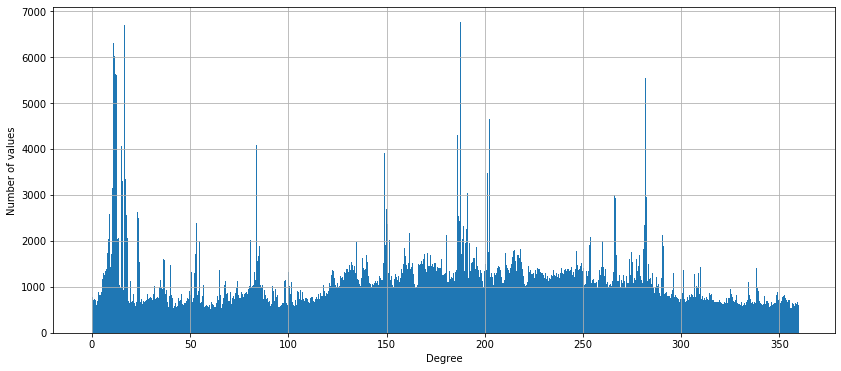

Unit,Number_of_Statements
Degree,1212941


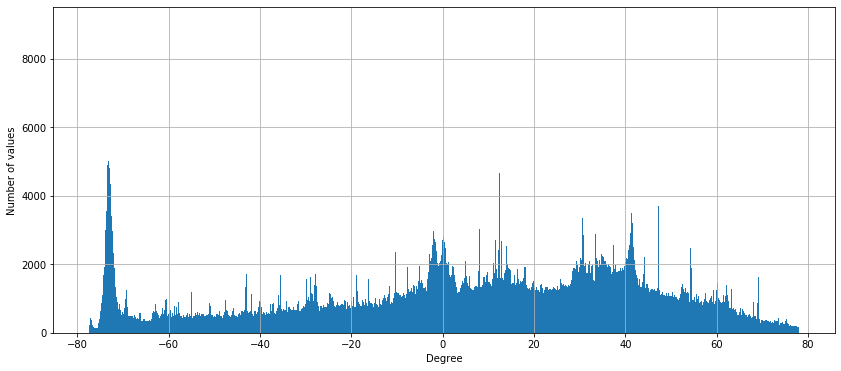

<Figure size 432x288 with 0 Axes>

In [166]:
try:
    #Initializing the dataframe pd_quantity_property with the list of top properties of datatype:quantity found above in the notebook  
    pd_quantity_property = pd.read_csv(os.path.join(os.getenv('OVERVIEW_FOLDER'),os.getenv('property_summary_quantity')),delimiter='\t')

    #Iterating over all the rows of dataframe
    for index,ele in pd_quantity_property.iterrows():

        #Ignoring the 'Other Instances' row
        if index>=int_k or ele['Property_Label'] =="Other Properties":
            break;

        # Extracting the "Pnode" corresponding to the property
        pnode = ele['Link'].split('/')[-1].split(":")[-1]

        #Extracting the 'Label' corresponding to the property
        prop_label = re.sub("[^0-9a-zA-Z]+", "_",  ele['Property_Label']) 

        quantity_distribution(pnode,prop_label)
except Exception as e:
    print(e)

/Users/shashanksaurabh/.local/lib/python3.7/site-packages/ipykernel_launcher.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


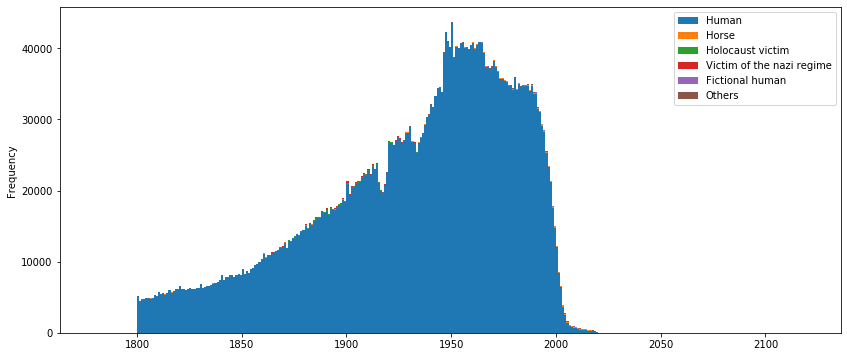

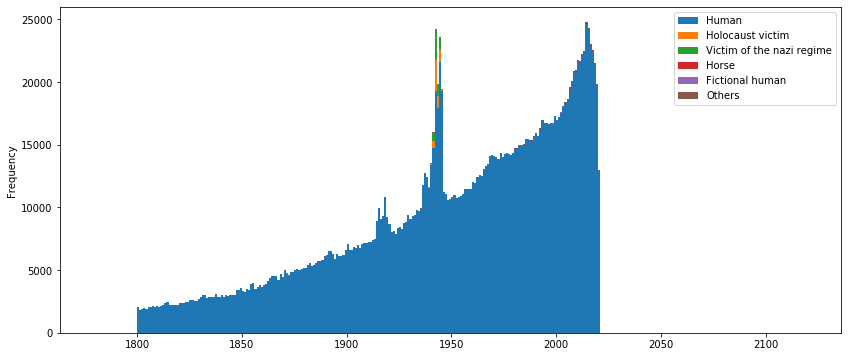

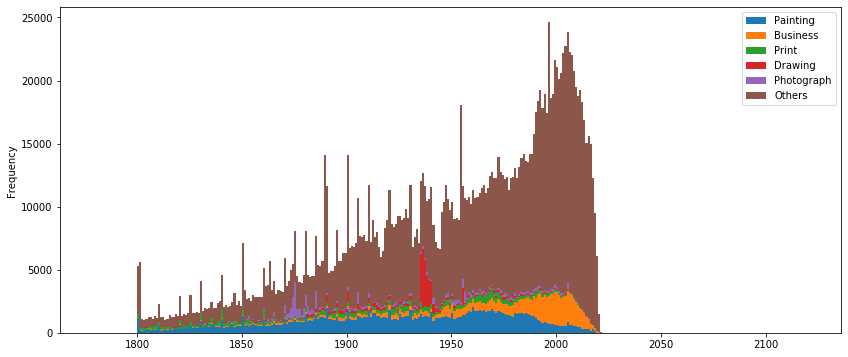

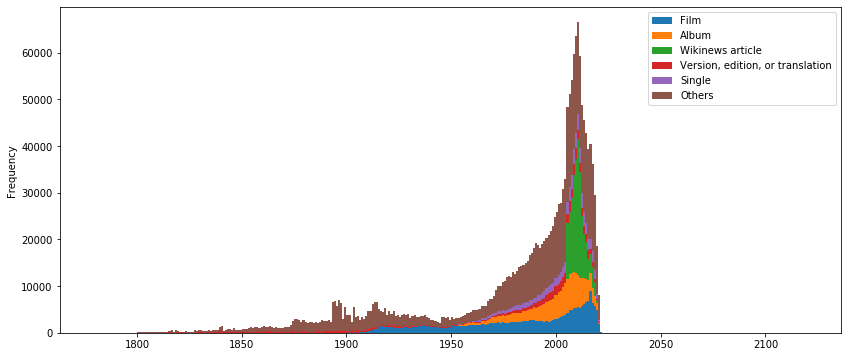

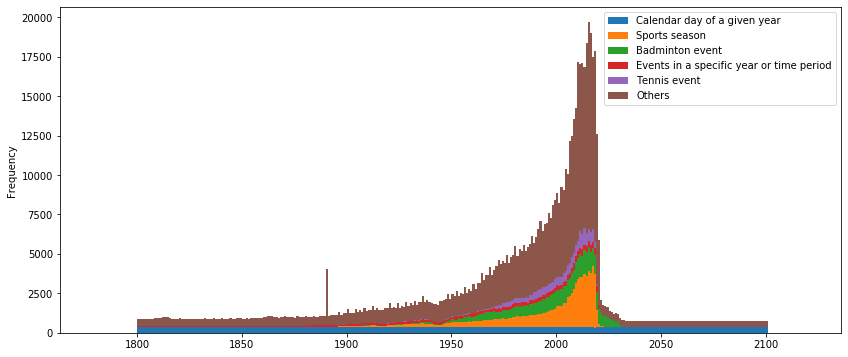

In [167]:
try:
    #Initializing the dataframe pd_time_property with the list of top properties of datatype:time found above in the notebook  
    pd_time_property = pd.read_csv(os.path.join(os.getenv('OVERVIEW_FOLDER'),os.getenv('property_summary_time')),delimiter='\t')
    printmd("Below are statistics for top five properties of Datatype:" + "time".capitalize(),'blue')
    for index,ele in pd_time_property.iterrows():

        #Ignoring the 'Other Instances' row
        if index>=int_k or ele['Property_Label'] =="Other Properties":
            break;

        # Extracting the "Pnode" corresponding to the property
        pnode = ele['Link'].split('/')[-1].split(":")[-1]

        #Extracting the 'Label' corresponding to the property
        prop_label = re.sub("[^0-9a-zA-Z]+", "_",  ele['Property_Label'])    

        time_distribution_stacked_saving = time_prop_distribution(pnode,prop_label,True,True)

        #Dynamically setting the name of the output file based on the name of property
        output_file_time_distribution = "Property_overview.time."+prop_label+".year_distibution.tsv"

        #Saving the dataframe
        time_distribution_stacked_saving.to_csv(os.path.join(os.getenv('PROPERTY_OVERVIEW'),output_file_time_distribution),sep='\t')
except Exception as e:
    print(e)

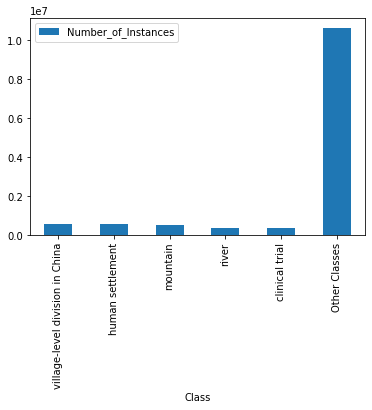

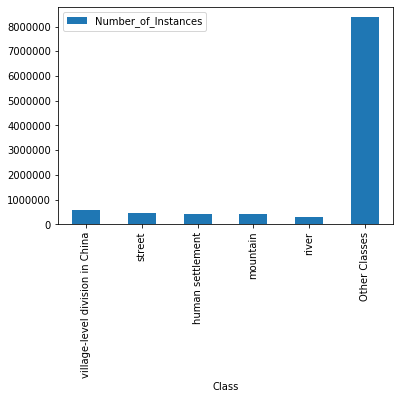

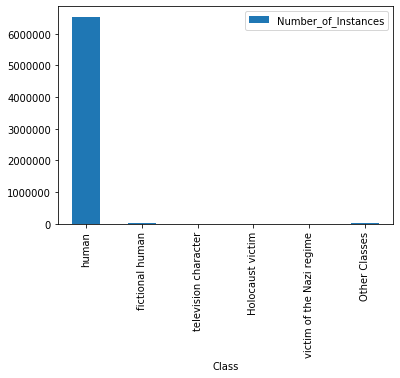

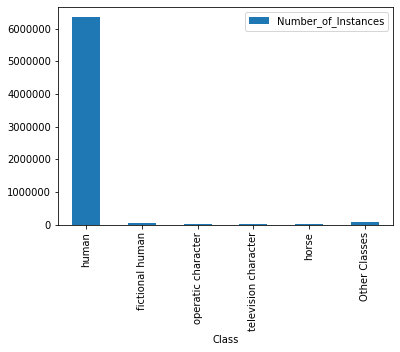

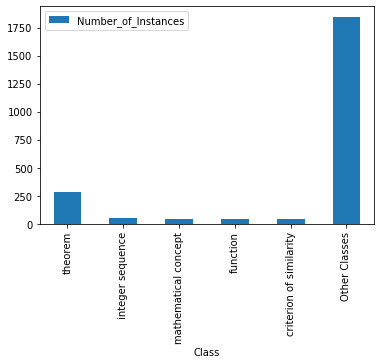

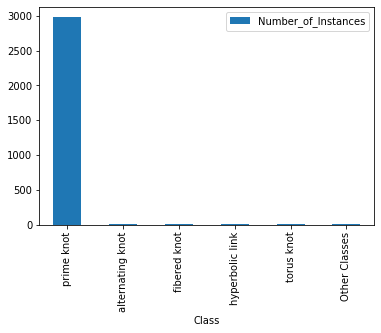

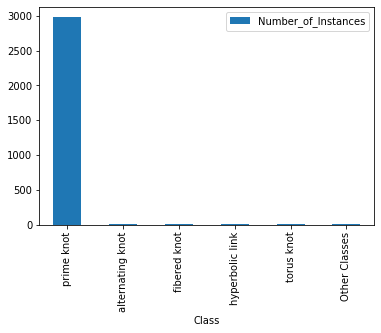

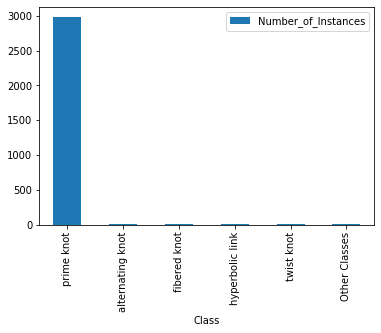

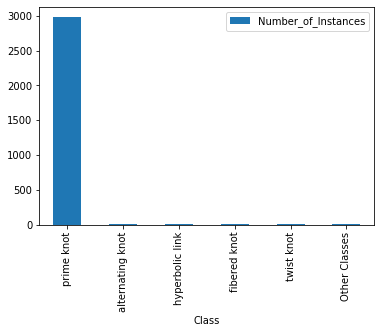

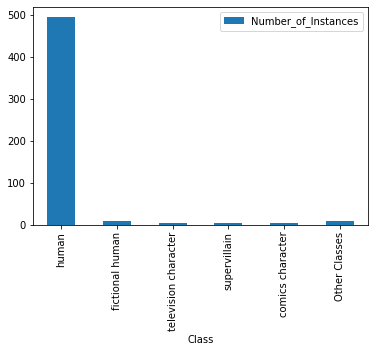

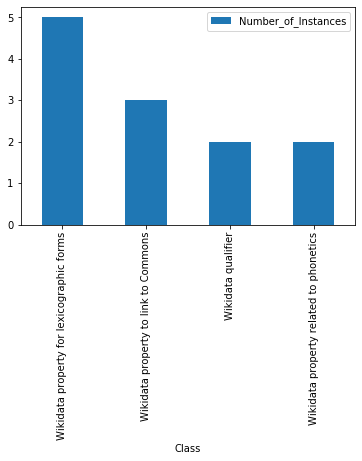

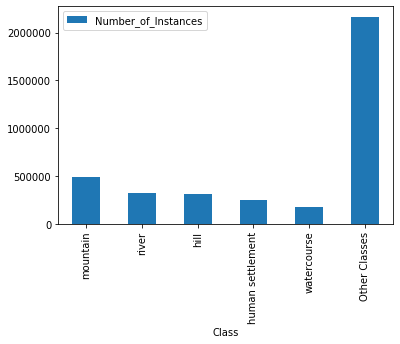

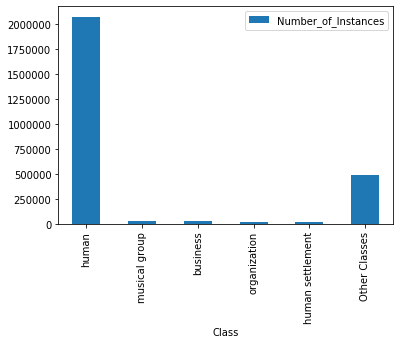

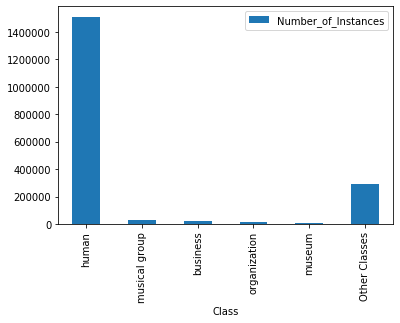

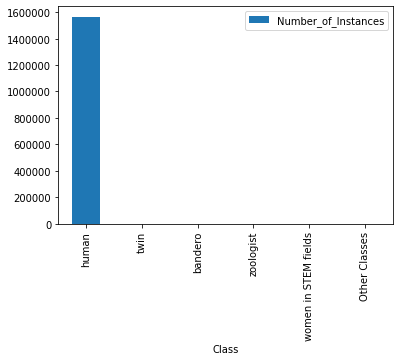

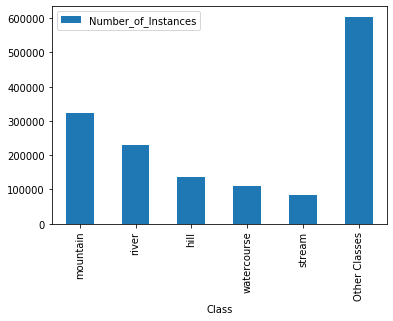

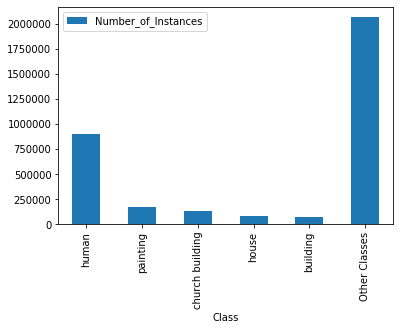

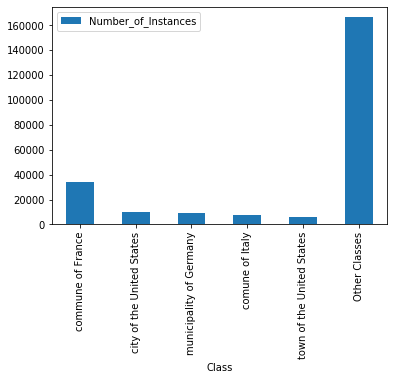

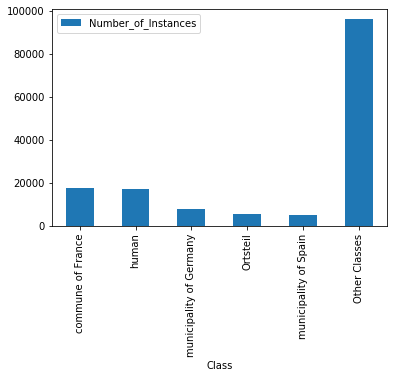

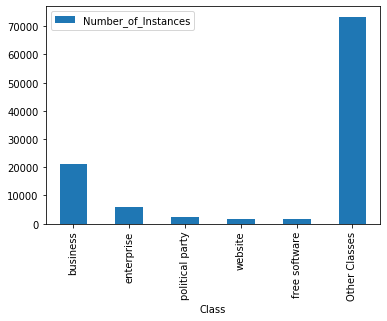

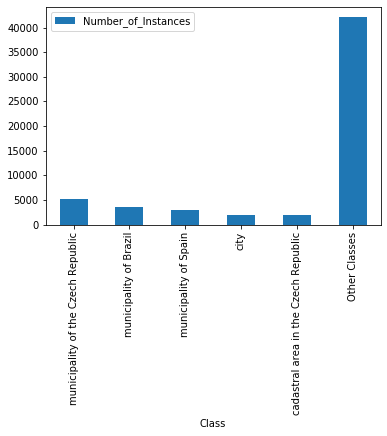

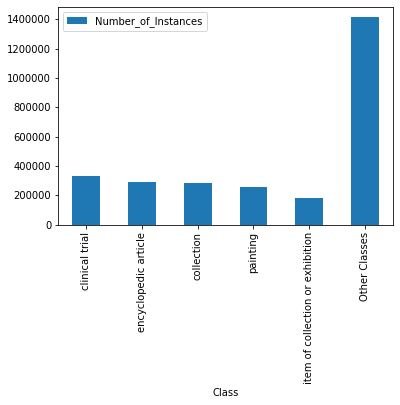

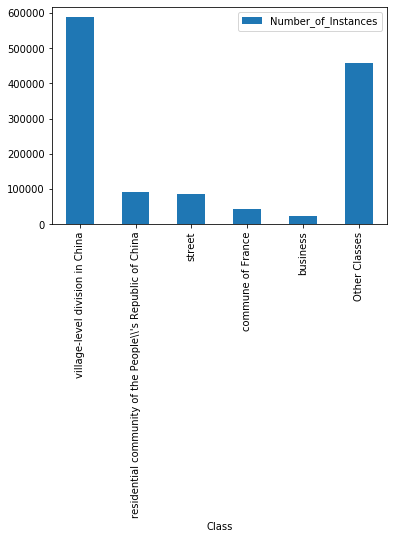

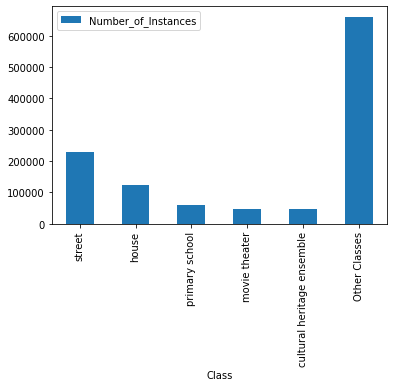

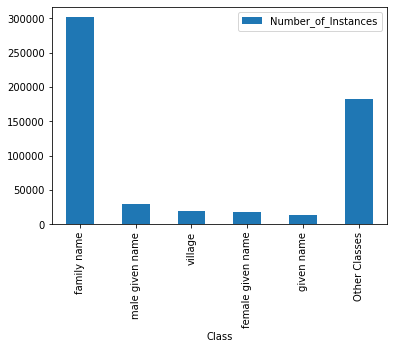

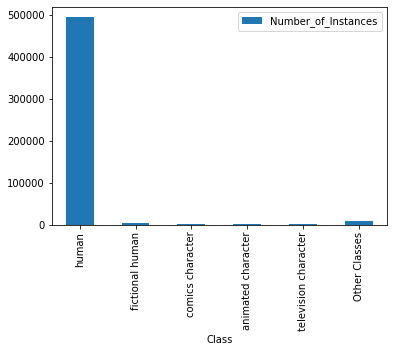

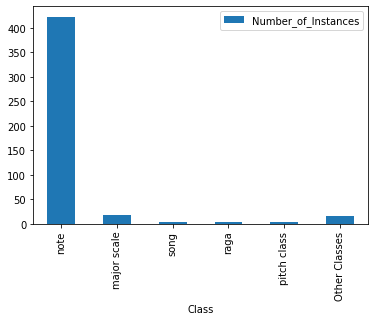

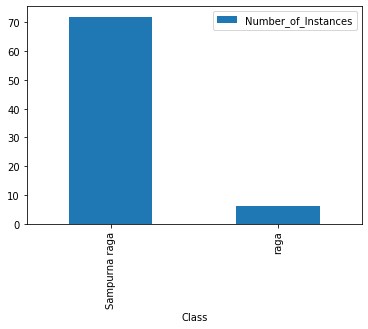

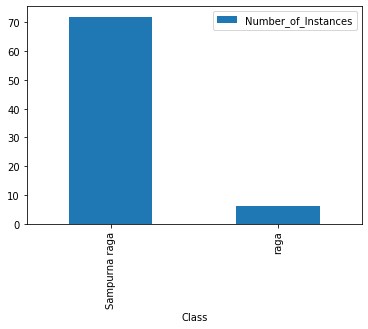

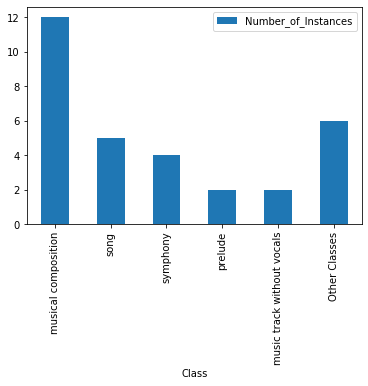

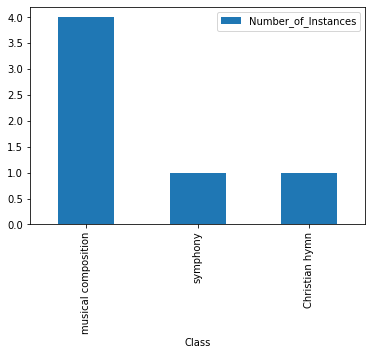

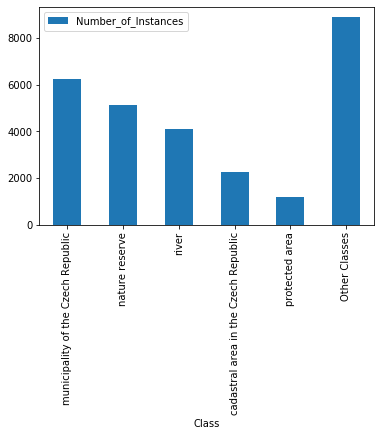

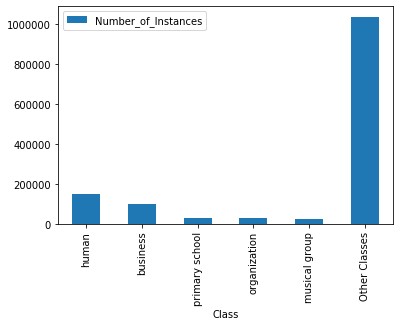

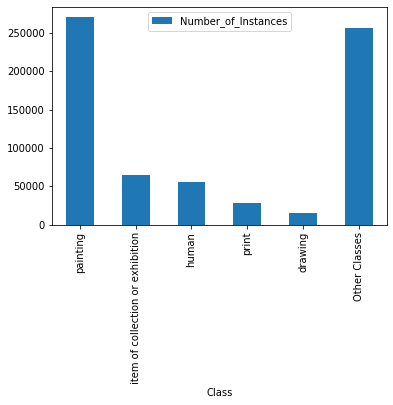

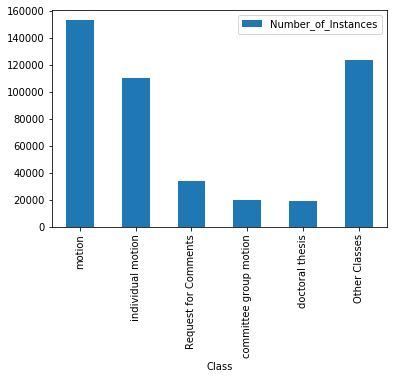

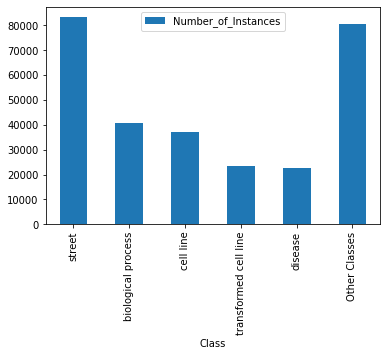

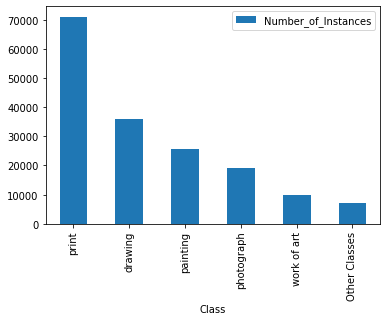

In [171]:
try:
    types_with_fileName = [
            ("wikibase_item","Wikibase_item","property_summary_wikibase_item"),
            ("math","Math","property_summary_math"),
            ("wikibase_form","Wikibase-form","property_summary_wikibase_form"),
            ("external_id","External-id","property_summary_external_id"),
            ("commonsMedia","CommonsMedia","property_summary_commonsMedia"),
            ("monolingualtext","Monolingualtext","property_summary_monolingualtext"),
            ("musical_notation","Musical-notation","property_summary_musical_notation"),
            ("geo_shape","Geo-shape","property_summary_geo_shape"),
            ("url","Url","property_summary_url"),
        ]

    for property_type,property_head,property_file in types_with_fileName:
        #Initializing the dataframe pd_time_property with the list of top properties of datatype:time found above in the notebook  
        pd_property = pd.read_csv(os.path.join(os.getenv('OVERVIEW_FOLDER'),os.getenv(property_file)),delimiter='\t')
        printmd("Below are statistics for top properties of Datatype:" + property_head.capitalize(),'blue')
        for index,ele in pd_property.iterrows():

            #Ignoring the 'Other Instances' row
            if index>=int_k or ele['Property_Label'] =="Other Properties":
                break;

            # Extracting the "Pnode" corresponding to the property
            pnode = ele['Link'].split('/')[-1].split(":")[-1]

            if pnode == "P31":
                continue

            #Extracting the 'Label' corresponding to the property
            prop_label = re.sub("[^0-9a-zA-Z]+", "_",  ele['Property_Label'])

            property_distribution(pnode,property_type,prop_label)
except Exception as e:
    print(e)

In [23]:
try:
    cmd_coord_distribution_class = "$kgtk query  -i $WIKIDATA_PARTS/$globe_coordinate -i $WIKIDATA_PARTS/$wikibase_item -i $WIKIDATA_PARTS/$label --graph-cache $STORE \
           -o $PROPERTY_OVERVIEW/__output_file \
           --match 'coordinate: (n1)-[l{label:llab}]->(n2), item: (n1)-[r{label:llab2}]->(class:__class) ' \
           --return 'distinct n2 as coordinate, kgtk_geo_coords_lat(n2) as latitude, kgtk_geo_coords_long(n2) as longitude, count(n2) as Number_of_points  '\
           --where 'llab in [\"__prop\"] AND llab2 in [\"P31\"]' \
           --order-by 'count(n2) desc'"

    cmd_distribution = "$kgtk query -i $WIKIDATA_PARTS/$globe_coordinate -i $WIKIDATA_PARTS/$wikibase_item  -i $WIKIDATA_PARTS/$label --graph-cache $STORE \
        -o $PROPERTY_OVERVIEW/__output_file \
        --match  'coordinate: (n1)-[r{label:llab}]->(v), item:(n1)-[l{label:llab2}]->(class), label:(class)-[:label]->(class_with_label)' \
        --return 'distinct kgtk_lqstring_text(class_with_label) as Class, count(kgtk_lqstring_text(class_with_label)) as Number_of_Instances, class as Qnode' \
        --where 'llab in [\"__prop\"] AND llab2 in [\"P31\"] AND kgtk_lqstring_lang_suffix(class_with_label) = \"en\" ' \
        --order-by 'Number_of_Instances desc' "

    #Initializing the dataframe pd_time_property with the list of top properties of datatype:time found above in the notebook  
    pd_coord_property = pd.read_csv(os.path.join(os.getenv('OVERVIEW_FOLDER'),os.getenv('property_summary_globe_coordinate')),delimiter='\t')
    for index,ele in pd_coord_property.iterrows():
        #Ignoring the 'Other Instances' row
        if index>=int_k or ele['Property_Label'] =="Other Properties":
            break;

        # Extracting the "Pnode" corresponding to the property
        pnode = ele['Link'].split('/')[-1].split(":")[-1]

        #Extracting the 'Label' corresponding to the property
        prop_label = re.sub("[^0-9a-zA-Z]+", "_", ele['Property_Label'])

        printmd("Below is the distribution of coordinate for Property:" + prop_label.capitalize(),'blue')

        output_file_class_distribution= "Property_overview.globe_coordinate."+prop_label+".class_distribution.tsv"
        property_class_distribution = run_command_return_df(cmd_distribution,"PROPERTY_OVERVIEW",output_file_class_distribution,{"__output_file":output_file_class_distribution,"__prop":pnode},save=True,restart=True);
        
        if(len(property_class_distribution)>0):
            for index2,ele2 in property_class_distribution.iterrows():        
                if index2>=int_k or ele['Property_Label'] =="Other Classes":
                    break;

                class_label = re.sub("[^0-9a-zA-Z]+", "_", ele2['Class'])

                qnode = ele2["Qnode"]

                #Dynamically setting the name of the output file based on the name of property
                output_file_coord_destribution = "Property_overview.globe_coordinate."+prop_label+"."+class_label+".distribution.tsv";

                #Running command cmd_coord_distribution_class
                coordinate_destribution = run_command_return_df(cmd_coord_distribution_class,"PROPERTY_OVERVIEW",output_file_coord_destribution,{"__output_file":output_file_coord_destribution,"__prop":pnode,"__class":qnode},save=True,restart=True);
                printmd("Below is the distribution of coordinate for Property:" + prop_label.capitalize()+" for Class:"+class_label.capitalize(),'blue')
                if(len(coordinate_destribution)>0):
                    display(HTML(coordinate_destribution[:int_k].to_html(index=False)))
                else:
                    printmd("There is no information about the coordinates for this class")
        else:
            printmd("There is no information about the classes(identified by 'P31') in this subgraph")
except Exception as e:
    print(e)

coordinate,latitude,longitude,Number_of_points
@52.880111111111/-3.3819111111111,52.880111,-3.381911,17
@-62.46667/-60.78333,-62.466670,-60.783330,9
@-62.45/-60.78333,-62.450000,-60.783330,7
@52.787875/-3.6883611111111,52.787875,-3.688361,7
@79.666666666667/12.5,79.666667,12.500000,7


coordinate,latitude,longitude,Number_of_points
@18.5/-69.983333333333,18.500000,-69.983333,55
@-24.84/29.803889,-24.840000,29.803889,44
@36.56666667/36.15,36.566667,36.150000,30
@-28.133333/31.866667,-28.133333,31.866667,25
@-23.466667/29.183333,-23.466667,29.183333,16


coordinate,latitude,longitude,Number_of_points
@46.491111/26.986944,46.491111,26.986944,23
@46.0855/25.6712,46.085500,25.671200,15
@46.0024/25.6646,46.002400,25.664600,13
@-20.016666666667/-158.11666666667,-20.016667,-158.116667,10
@45.9753/25.5425,45.975300,25.542500,10


coordinate,latitude,longitude,Number_of_points
@57.69965/12.01565,57.699650,12.015650,12
@50.3439522222/16.1515463889,50.343952,16.151546,9
@55.890166666667/37.527861111111,55.890167,37.527861,8
@55.995/37.189444444444,55.995000,37.189444,8
@55.800833333333/37.505833333333,55.800833,37.505833,7


coordinate,latitude,longitude,Number_of_points
@36.670938888889/48.485111111111,36.670939,48.485111,63
@35.572269444444/53.396047222222,35.572269,53.396047,27
@36.3/59.6,36.300000,59.600000,14
@30.203308333333/53.179011111111,30.203308,53.179011,7
@22.516666666667/114.16666666667,22.516667,114.166667,6


coordinate,latitude,longitude,Number_of_points
@37.751279/14.9942236,37.751279,14.994224,4
@40.8213963/14.4261967,40.821396,14.426197,3
@38.1621721/15.8896108,38.162172,15.889611,2
@41.1744664/14.2286706,41.174466,14.228671,2
@42.2969953/12.5363918,42.296995,12.536392,2


coordinate,latitude,longitude,Number_of_points
@57.6105/-2.9111,57.6105,-2.9111,2
@54.7658/-4.9406,54.7658,-4.9406,1
@54.7879/-4.414,54.7879,-4.4140,1
@54.791/-4.4868,54.7910,-4.4868,1
@54.8251/-4.4088,54.8251,-4.4088,1


coordinate,latitude,longitude,Number_of_points
@34.94297583/32.86270095,34.942976,32.862701,2
@34.64799788/32.95231227,34.647998,32.952312,1
@34.65000245/32.9122574,34.650002,32.912257,1
@34.65533522/32.98995646,34.655335,32.989956,1
@34.6653973/32.94770735,34.665397,32.947707,1


coordinate,latitude,longitude,Number_of_points
@30.1/47.5,30.10,47.50,2
@59.82/26.37,59.82,26.37,2
@-0.03/-75.17,-0.03,-75.17,1
@-0.5/166.93,-0.50,166.93,1
@-1.05/30.45,-1.05,30.45,1


coordinate,latitude,longitude,Number_of_points
@39.2965541/16.4255658,39.296554,16.425566,1
@39.2987254/16.320893,39.298725,16.320893,1
@39.3467419/16.5777031,39.346742,16.577703,1
@39.9201102/18.2770554,39.920110,18.277055,1
@39.9323549/18.2676742,39.932355,18.267674,1


coordinate,latitude,longitude,Number_of_points
@37.751279/14.9942236,37.751279,14.994224,3
@40.8213963/14.4261967,40.821396,14.426197,3
@40.9108358/14.4657977,40.910836,14.465798,2
@40.9407552/14.5362493,40.940755,14.536249,2
@41.1576472/14.5630363,41.157647,14.563036,2


coordinate,latitude,longitude,Number_of_points
@54.7347/-4.9925,54.7347,-4.9925,1
@54.7434/-4.5524,54.7434,-4.5524,1
@54.7451/-4.4931,54.7451,-4.4931,1
@54.7742/-4.0114,54.7742,-4.0114,1
@54.7856/-4.49,54.7856,-4.4900,1


coordinate,latitude,longitude,Number_of_points
@34.6278011/32.94355754,34.627801,32.943558,1
@34.64322382/32.90195772,34.643224,32.901958,1
@34.64765257/32.967972424,34.647653,32.967972,1
@34.65155959/32.94178504,34.651560,32.941785,1
@34.65451908/32.91890766,34.654519,32.918908,1


coordinate,latitude,longitude,Number_of_points
@29.1012/46.55325,29.101200,46.553250,2
@58.32290042/21.76433444,58.322900,21.764334,2
@-0.37/-91.55,-0.370000,-91.550000,1
@-0.62444444/8.70805556,-0.624444,8.708056,1
@-0.85944444444444/169.53694444444,-0.859444,169.536944,1


coordinate,latitude,longitude,Number_of_points
@39.2703106/16.319421,39.270311,16.319421,1
@39.2788297/16.3426145,39.278830,16.342614,1
@39.2919027/16.3086383,39.291903,16.308638,1
@39.8571082/18.1997085,39.857108,18.199708,1
@39.9107657/18.1998286,39.910766,18.199829,1


$kgtk query -i $WIKIDATA_PARTS/$globe_coordinate -i $WIKIDATA_PARTS/$wikibase_item  -i $WIKIDATA_PARTS/$label --graph-cache $STORE         -o $PROPERTY_OVERVIEW/Property_overview.globe_coordinate.coordinates_of_easternmost_point.class_distribution.tsv         --match  'coordinate: (n1)-[r{label:llab}]->(v), item:(n1)-[l{label:llab2}]->(class), label:(class)-[:label]->(class_with_label)'         --return 'distinct kgtk_lqstring_text(class_with_label) as Class, count(kgtk_lqstring_text(class_with_label)) as Number_of_Instances, class as Qnode'         --where 'llab in ["P1334"] AND llab2 in ["P31"] AND kgtk_lqstring_lang_suffix(class_with_label) = "en" '         --order-by 'Number_of_Instances desc' 

[2021-01-04 03:32:40 query]: SQL Translation:
---------------------------------------------
  SELECT DISTINCT kgtk_lqstring_text(graph_35_c3."node2") "Class", count(kgtk_lqstring_text(graph_35_c3."node2")) "Number_of_Instances", graph_35_c3."node1" "Qnode"
     FROM graph_20 AS graph_20_c2,

coordinate,latitude,longitude,Number_of_points
@37.751279/14.9942236,37.751279,14.994224,3
@42.5952589/11.9517878,42.595259,11.951788,3
@38.6805578/16.5594268,38.680558,16.559427,2
@39.3350113/16.3706525,39.335011,16.370652,2
@39.9655001/16.6303652,39.965500,16.630365,2


$kgtk query  -i $WIKIDATA_PARTS/$globe_coordinate -i $WIKIDATA_PARTS/$wikibase_item -i $WIKIDATA_PARTS/$label --graph-cache $STORE            -o $PROPERTY_OVERVIEW/Property_overview.globe_coordinate.coordinates_of_easternmost_point.civil_parish.distribution.tsv            --match 'coordinate: (n1)-[l{label:llab}]->(n2), item: (n1)-[r{label:llab2}]->(class:Q5124673) '            --return 'distinct n2 as coordinate, kgtk_geo_coords_lat(n2) as latitude, kgtk_geo_coords_long(n2) as longitude, count(n2) as Number_of_points  '           --where 'llab in ["P1334"] AND llab2 in ["P31"]'            --order-by 'count(n2) desc'

[2021-01-04 04:32:13 query]: SQL Translation:
---------------------------------------------
  SELECT DISTINCT graph_28_c1."node2" "coordinate", kgtk_geo_coords_lat(graph_28_c1."node2") "latitude", kgtk_geo_coords_long(graph_28_c1."node2") "longitude", count(graph_28_c1."node2") "Number_of_points"
     FROM graph_20 AS graph_20_c2, graph_28 AS graph_28_c1
     WHERE graph_

coordinate,latitude,longitude,Number_of_points
@54.637/-4.8526,54.6370,-4.8526,1
@54.7071/-4.3862,54.7071,-4.3862,1
@54.7113/-4.3491,54.7113,-4.3491,1
@54.7824/-4.5194,54.7824,-4.5194,1
@54.7993/-4.3419,54.7993,-4.3419,1


$kgtk query  -i $WIKIDATA_PARTS/$globe_coordinate -i $WIKIDATA_PARTS/$wikibase_item -i $WIKIDATA_PARTS/$label --graph-cache $STORE            -o $PROPERTY_OVERVIEW/Property_overview.globe_coordinate.coordinates_of_easternmost_point.Communities_of_Cyprus_Republic.distribution.tsv            --match 'coordinate: (n1)-[l{label:llab}]->(n2), item: (n1)-[r{label:llab2}]->(class:Q29414133) '            --return 'distinct n2 as coordinate, kgtk_geo_coords_lat(n2) as latitude, kgtk_geo_coords_long(n2) as longitude, count(n2) as Number_of_points  '           --where 'llab in ["P1334"] AND llab2 in ["P31"]'            --order-by 'count(n2) desc'

[2021-01-04 04:32:17 query]: SQL Translation:
---------------------------------------------
  SELECT DISTINCT graph_28_c1."node2" "coordinate", kgtk_geo_coords_lat(graph_28_c1."node2") "latitude", kgtk_geo_coords_long(graph_28_c1."node2") "longitude", count(graph_28_c1."node2") "Number_of_points"
     FROM graph_20 AS graph_20_c2, graph_28 AS graph_28_c

coordinate,latitude,longitude,Number_of_points
@34.94002077/32.90510131,34.940021,32.905101,2
@34.56763026/33.03601888,34.567630,33.036019,1
@34.62200951/33.00604228,34.622010,33.006042,1
@34.64410127/33.0121002,34.644101,33.012100,1
@34.64946243/32.9241359,34.649462,32.924136,1


$kgtk query  -i $WIKIDATA_PARTS/$globe_coordinate -i $WIKIDATA_PARTS/$wikibase_item -i $WIKIDATA_PARTS/$label --graph-cache $STORE            -o $PROPERTY_OVERVIEW/Property_overview.globe_coordinate.coordinates_of_easternmost_point.sovereign_state.distribution.tsv            --match 'coordinate: (n1)-[l{label:llab}]->(n2), item: (n1)-[r{label:llab2}]->(class:Q3624078) '            --return 'distinct n2 as coordinate, kgtk_geo_coords_lat(n2) as latitude, kgtk_geo_coords_long(n2) as longitude, count(n2) as Number_of_points  '           --where 'llab in ["P1334"] AND llab2 in ["P31"]'            --order-by 'count(n2) desc'

[2021-01-04 04:32:25 query]: SQL Translation:
---------------------------------------------
  SELECT DISTINCT graph_28_c1."node2" "coordinate", kgtk_geo_coords_lat(graph_28_c1."node2") "latitude", kgtk_geo_coords_long(graph_28_c1."node2") "longitude", count(graph_28_c1."node2") "Number_of_points"
     FROM graph_20 AS graph_20_c2, graph_28 AS graph_28_c1
     WHERE gra

coordinate,latitude,longitude,Number_of_points
@28.822777777778/48.784722222222,28.822778,48.784722,2
@59.37047831/28.20894778,59.370478,28.208948,2
@-0.521/166.95813,-0.521000,166.958130,1
@-0.61746/14.5266,-0.617460,14.526600,1
@-11.916666666667/170.2,-11.916667,170.200000,1


$kgtk query  -i $WIKIDATA_PARTS/$globe_coordinate -i $WIKIDATA_PARTS/$wikibase_item -i $WIKIDATA_PARTS/$label --graph-cache $STORE            -o $PROPERTY_OVERVIEW/Property_overview.globe_coordinate.coordinates_of_easternmost_point.abolished_municipality_in_Italy.distribution.tsv            --match 'coordinate: (n1)-[l{label:llab}]->(n2), item: (n1)-[r{label:llab2}]->(class:Q3685476) '            --return 'distinct n2 as coordinate, kgtk_geo_coords_lat(n2) as latitude, kgtk_geo_coords_long(n2) as longitude, count(n2) as Number_of_points  '           --where 'llab in ["P1334"] AND llab2 in ["P31"]'            --order-by 'count(n2) desc'

[2021-01-04 04:32:36 query]: SQL Translation:
---------------------------------------------
  SELECT DISTINCT graph_28_c1."node2" "coordinate", kgtk_geo_coords_lat(graph_28_c1."node2") "latitude", kgtk_geo_coords_long(graph_28_c1."node2") "longitude", count(graph_28_c1."node2") "Number_of_points"
     FROM graph_20 AS graph_20_c2, graph_28 AS graph_28_c

coordinate,latitude,longitude,Number_of_points
@39.2823414/16.3435206,39.282341,16.343521,1
@39.2823866/16.5495493,39.282387,16.549549,1
@39.3088643/16.5967686,39.308864,16.596769,1
@39.8769339/18.2976615,39.876934,18.297662,1
@39.919884/18.2753835,39.919884,18.275384,1


$kgtk query -i $WIKIDATA_PARTS/$globe_coordinate -i $WIKIDATA_PARTS/$wikibase_item  -i $WIKIDATA_PARTS/$label --graph-cache $STORE         -o $PROPERTY_OVERVIEW/Property_overview.globe_coordinate.coordinates_of_southernmost_point.class_distribution.tsv         --match  'coordinate: (n1)-[r{label:llab}]->(v), item:(n1)-[l{label:llab2}]->(class), label:(class)-[:label]->(class_with_label)'         --return 'distinct kgtk_lqstring_text(class_with_label) as Class, count(kgtk_lqstring_text(class_with_label)) as Number_of_Instances, class as Qnode'         --where 'llab in ["P1333"] AND llab2 in ["P31"] AND kgtk_lqstring_lang_suffix(class_with_label) = "en" '         --order-by 'Number_of_Instances desc' 

[2021-01-04 04:32:43 query]: SQL Translation:
---------------------------------------------
  SELECT DISTINCT kgtk_lqstring_text(graph_35_c3."node2") "Class", count(kgtk_lqstring_text(graph_35_c3."node2")) "Number_of_Instances", graph_20_c2."node2" "Qnode"
     FROM graph_20 AS graph_20_c2

coordinate,latitude,longitude,Number_of_points
@37.751279/14.9942236,37.751279,14.994224,2
@39.2997102/16.132919,39.299710,16.132919,2
@39.9945391/18.3088211,39.994539,18.308821,2
@40.2361549/15.0681879,40.236155,15.068188,2
@40.6338322/16.0311112,40.633832,16.031111,2


$kgtk query  -i $WIKIDATA_PARTS/$globe_coordinate -i $WIKIDATA_PARTS/$wikibase_item -i $WIKIDATA_PARTS/$label --graph-cache $STORE            -o $PROPERTY_OVERVIEW/Property_overview.globe_coordinate.coordinates_of_southernmost_point.civil_parish.distribution.tsv            --match 'coordinate: (n1)-[l{label:llab}]->(n2), item: (n1)-[r{label:llab2}]->(class:Q5124673) '            --return 'distinct n2 as coordinate, kgtk_geo_coords_lat(n2) as latitude, kgtk_geo_coords_long(n2) as longitude, count(n2) as Number_of_points  '           --where 'llab in ["P1333"] AND llab2 in ["P31"]'            --order-by 'count(n2) desc'

[2021-01-04 05:22:16 query]: SQL Translation:
---------------------------------------------
  SELECT DISTINCT graph_28_c1."node2" "coordinate", kgtk_geo_coords_lat(graph_28_c1."node2") "latitude", kgtk_geo_coords_long(graph_28_c1."node2") "longitude", count(graph_28_c1."node2") "Number_of_points"
     FROM graph_20 AS graph_20_c2, graph_28 AS graph_28_c1
     WHERE graph

coordinate,latitude,longitude,Number_of_points
@57.5694/-3.2012,57.5694,-3.2012,2
@54.6341/-4.8552,54.6341,-4.8552,1
@54.6777/-4.3937,54.6777,-4.3937,1
@54.6866/-4.4285,54.6866,-4.4285,1
@54.7346/-4.5495,54.7346,-4.5495,1


$kgtk query  -i $WIKIDATA_PARTS/$globe_coordinate -i $WIKIDATA_PARTS/$wikibase_item -i $WIKIDATA_PARTS/$label --graph-cache $STORE            -o $PROPERTY_OVERVIEW/Property_overview.globe_coordinate.coordinates_of_southernmost_point.Communities_of_Cyprus_Republic.distribution.tsv            --match 'coordinate: (n1)-[l{label:llab}]->(n2), item: (n1)-[r{label:llab2}]->(class:Q29414133) '            --return 'distinct n2 as coordinate, kgtk_geo_coords_lat(n2) as latitude, kgtk_geo_coords_long(n2) as longitude, count(n2) as Number_of_points  '           --where 'llab in ["P1333"] AND llab2 in ["P31"]'            --order-by 'count(n2) desc'

[2021-01-04 05:22:20 query]: SQL Translation:
---------------------------------------------
  SELECT DISTINCT graph_28_c1."node2" "coordinate", kgtk_geo_coords_lat(graph_28_c1."node2") "latitude", kgtk_geo_coords_long(graph_28_c1."node2") "longitude", count(graph_28_c1."node2") "Number_of_points"
     FROM graph_20 AS graph_20_c2, graph_28 AS graph_28_

coordinate,latitude,longitude,Number_of_points
@34.90356625/32.87900878,34.903566,32.879009,2
@34.56240256/33.02658388,34.562403,33.026584,1
@34.61197921/33.00587062,34.611979,33.005871,1
@34.62211129/33.00619934,34.622111,33.006199,1
@34.64020294/32.70359288,34.640203,32.703593,1


$kgtk query  -i $WIKIDATA_PARTS/$globe_coordinate -i $WIKIDATA_PARTS/$wikibase_item -i $WIKIDATA_PARTS/$label --graph-cache $STORE            -o $PROPERTY_OVERVIEW/Property_overview.globe_coordinate.coordinates_of_southernmost_point.sovereign_state.distribution.tsv            --match 'coordinate: (n1)-[l{label:llab}]->(n2), item: (n1)-[r{label:llab2}]->(class:Q3624078) '            --return 'distinct n2 as coordinate, kgtk_geo_coords_lat(n2) as latitude, kgtk_geo_coords_long(n2) as longitude, count(n2) as Number_of_points  '           --where 'llab in ["P1333"] AND llab2 in ["P31"]'            --order-by 'count(n2) desc'

[2021-01-04 05:22:28 query]: SQL Translation:
---------------------------------------------
  SELECT DISTINCT graph_28_c1."node2" "coordinate", kgtk_geo_coords_lat(graph_28_c1."node2") "latitude", kgtk_geo_coords_long(graph_28_c1."node2") "longitude", count(graph_28_c1."node2") "Number_of_points"
     FROM graph_20 AS graph_20_c2, graph_28 AS graph_28_c1
     WHERE gr

coordinate,latitude,longitude,Number_of_points
@28.52445/47.70489,28.524450,47.704890,2
@57.50931687/26.6165632,57.509317,26.616563,2
@-0.013277777777778/6.5233611111111,-0.013278,6.523361,1
@-0.69444444444444/73.155,-0.694444,73.155000,1
@-1.47368/5.64233,-1.473680,5.642330,1


$kgtk query  -i $WIKIDATA_PARTS/$globe_coordinate -i $WIKIDATA_PARTS/$wikibase_item -i $WIKIDATA_PARTS/$label --graph-cache $STORE            -o $PROPERTY_OVERVIEW/Property_overview.globe_coordinate.coordinates_of_southernmost_point.abolished_municipality_in_Italy.distribution.tsv            --match 'coordinate: (n1)-[l{label:llab}]->(n2), item: (n1)-[r{label:llab2}]->(class:Q3685476) '            --return 'distinct n2 as coordinate, kgtk_geo_coords_lat(n2) as latitude, kgtk_geo_coords_long(n2) as longitude, count(n2) as Number_of_points  '           --where 'llab in ["P1333"] AND llab2 in ["P31"]'            --order-by 'count(n2) desc'

[2021-01-04 05:22:39 query]: SQL Translation:
---------------------------------------------
  SELECT DISTINCT graph_28_c1."node2" "coordinate", kgtk_geo_coords_lat(graph_28_c1."node2") "latitude", kgtk_geo_coords_long(graph_28_c1."node2") "longitude", count(graph_28_c1."node2") "Number_of_points"
     FROM graph_20 AS graph_20_c2, graph_28 AS graph_28_

coordinate,latitude,longitude,Number_of_points
@39.2364266/16.485242,39.236427,16.485242,1
@39.2703106/16.319421,39.270311,16.319421,1
@39.2756079/16.352178,39.275608,16.352178,1
@39.8571082/18.1997085,39.857108,18.199708,1
@39.8885758/18.2203805,39.888576,18.220381,1


In [24]:
try:
    df = pd.read_csv(os.path.join(os.getenv('WIKIDATA_PARTS'),os.getenv('geo_shape')),delimiter='\t',index_col=False)
    try:
        num_rows = min(int(K[1:-1]),len(df))
    except Exception as e:
        num_rows = min(int(K),len(df))
    df = df.sample(n=num_rows)
    printmd("Below are random samples from Geo-shape data" ,'blue')
    display(df)
    df.to_csv(os.path.join(os.getenv('PROPERTY_OVERVIEW'),os.getenv('geo_shape_random_samples')),sep='\t',index=False)
except Exception as e:
    print(e)

,id,node1,label,node2,rank,node2;wikidatatype
16041,Q805424-P3896-ab875f-2508fa19-0,Q805424,P3896,Data:Ballymena.map,normal,geo-shape
12364,Q368465-P3896-c84bf9-d44f6309-0,Q368465,P3896,"Data:Map of Skašov, Plzeň-jih District.map",normal,geo-shape
15855,Q779-P3896-e44000-feb17ea5-0,Q779,P3896,Data:Connecticut.map,normal,geo-shape
1671,Q11406389-P3896-a22605-933ffa7c-0,Q11406389,P3896,Data:Japan/election/2017/shuin1207.map,normal,geo-shape
8843,Q29579955-P3896-c9d101-6f9d8580-0,Q29579955,P3896,Data:/Sweden/Nature reserves/2020/Stora och Li...,normal,geo-shape


## Demonstration of Class overview and Property Overview

In [26]:
class_overview("Q483501","artist")

Label_,Pagerank,Link
Twenty-One,1.043620e-07,https://www.wikidata.org/wiki/Q2462196
Penny Pacheco,1.043620e-07,https://www.wikidata.org/wiki/Q70874415


Property Name,Instances,% Instances
instance of,2,100.0
given name,1,50.0
different from,1,50.0
occupation,1,50.0
place of birth,1,50.0
sex or gender,1,50.0


Property Name,Instances
different from,1


In [27]:
class_overview("Q483501","artist",number_of_outgoing_properties=3)

Label_,Pagerank,Link
Twenty-One,1.043620e-07,https://www.wikidata.org/wiki/Q2462196
Penny Pacheco,1.043620e-07,https://www.wikidata.org/wiki/Q70874415


Property Name,Instances,% Instances
instance of,2,100.0
given name,1,50.0
different from,1,50.0


Property Name,Instances
different from,1


# Property types
#### [ "time",
#### "wikibase_item",
#### "math",
#### "wikibase_form",
#### "quantity",
#### "string",
#### "external_id",
#### "commonsMedia",
#### "globe_coordinate",
#### "monolingualtext",
#### "musical_notation",
#### "geo_shape",
#### "url"
#### ]

/Users/shashanksaurabh/.local/lib/python3.7/site-packages/ipykernel_launcher.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


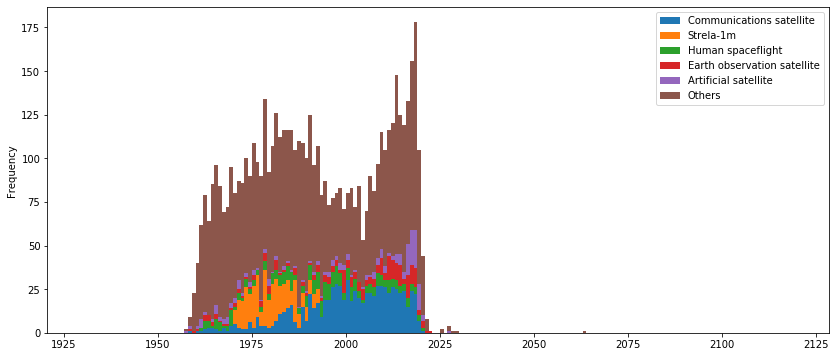

In [28]:
property_overview("P619","space_craft_launch_time","time")

## Can in zoom into between _min_year and _max_year 
## Can also increase the number of classes

/Users/shashanksaurabh/.local/lib/python3.7/site-packages/ipykernel_launcher.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


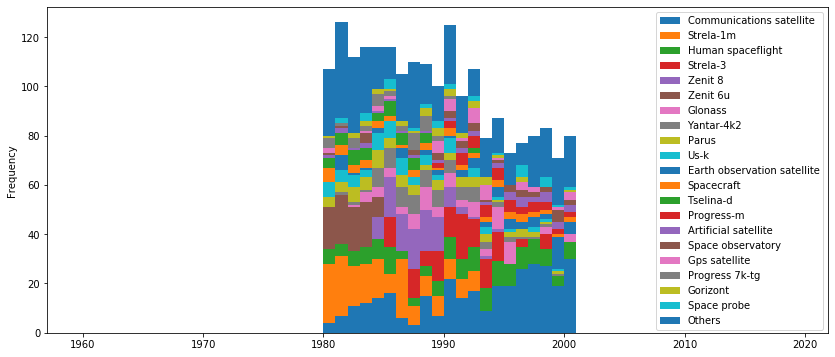

In [29]:
property_overview("P619","space_craft_launch_time","time",_restart=True,_min_year=1980,_max_year=2000,number_of_unique_classes=20)

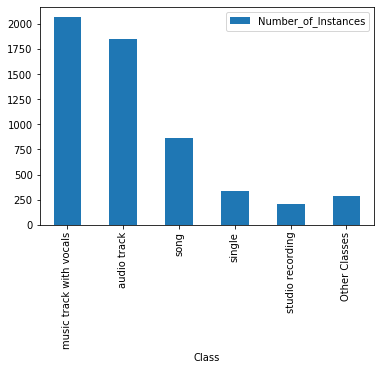

In [24]:
property_overview("P2207","spotify_track","external_id")

## Can set the number of unique classes also

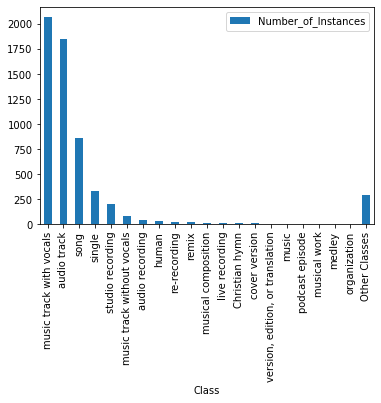

In [31]:
property_overview("P2207","spotify_track","external_id",number_of_unique_classes=20)

/Users/shashanksaurabh/.local/lib/python3.7/site-packages/ipykernel_launcher.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


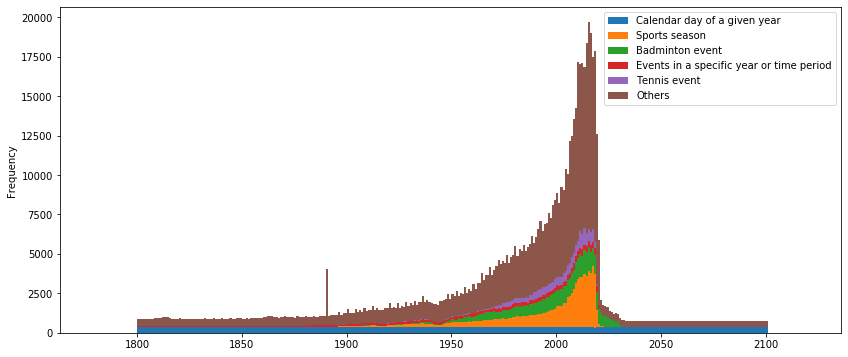

In [32]:
property_overview("P585","point_in_time","time")

/Users/shashanksaurabh/.local/lib/python3.7/site-packages/ipykernel_launcher.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


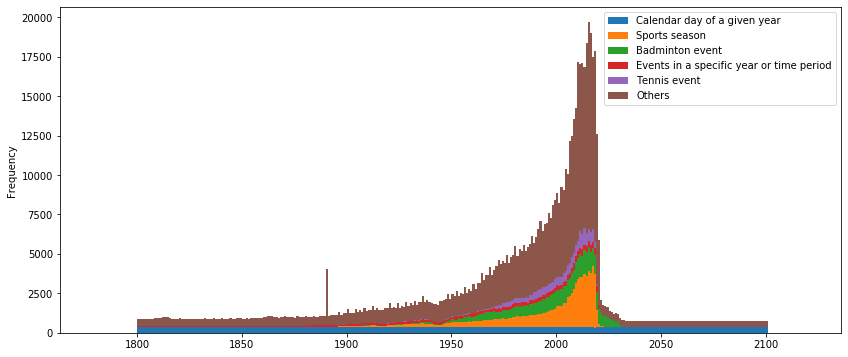

In [33]:
property_overview("P585","point_in_time","time")

/Users/shashanksaurabh/.local/lib/python3.7/site-packages/ipykernel_launcher.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


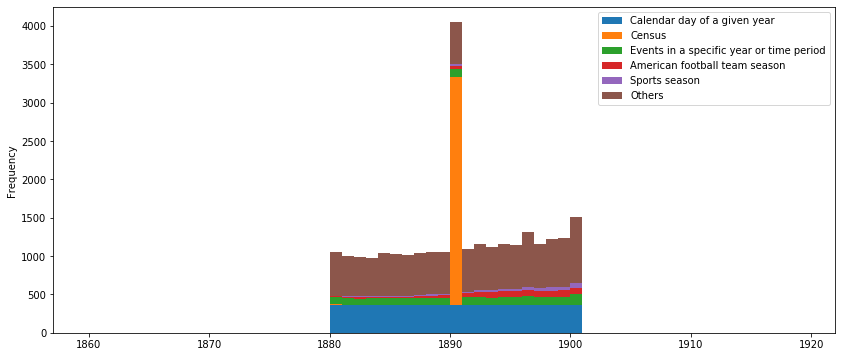

In [34]:
property_overview("P585","point_in_time","time",_min_year=1880,_max_year=1900,number_of_unique_classes=5)

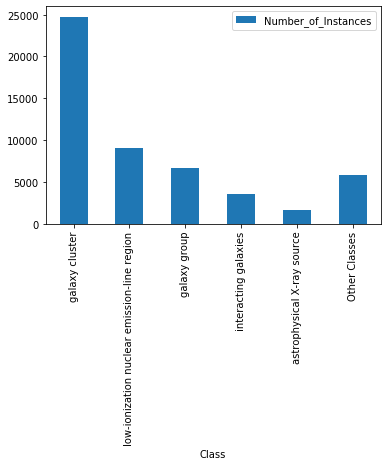

Unit,Number_of_Statements
Number,23429


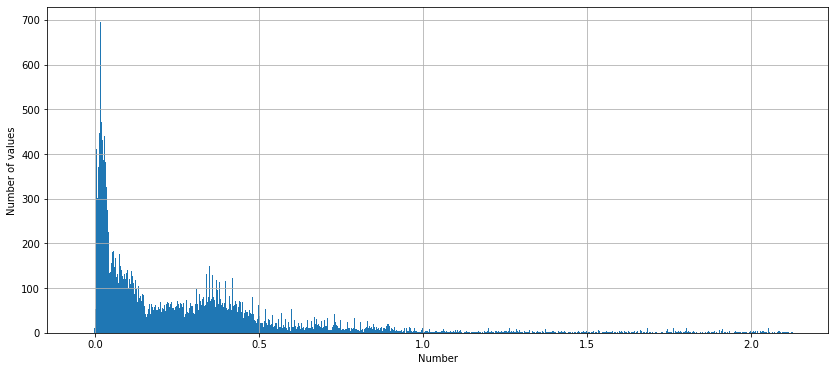

<Figure size 432x288 with 0 Axes>

In [40]:
property_overview("P1090","redshift","quantity")

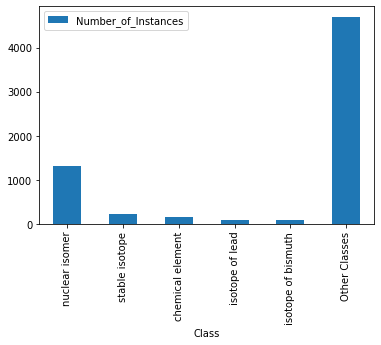

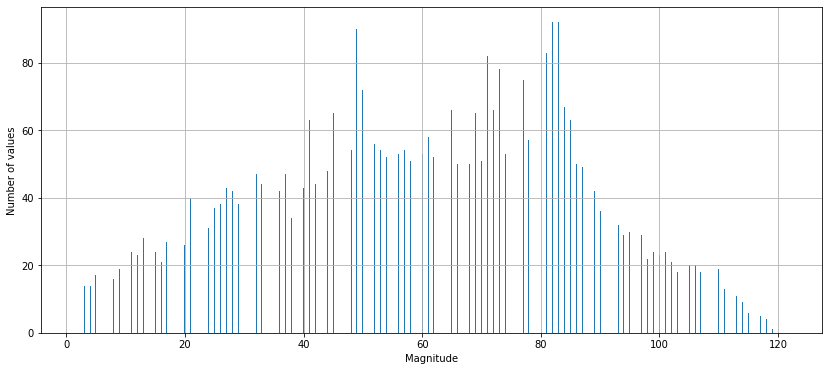

<Figure size 432x288 with 0 Axes>

In [39]:
property_overview("P1086","atomic number","quantity")

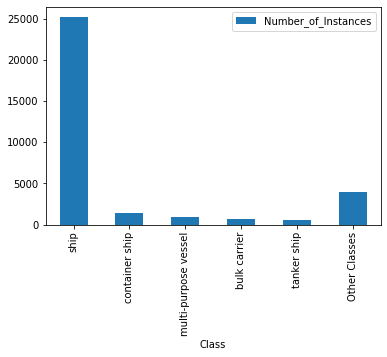

Unit,Number_of_Statements
Gross register ton,32
Number,12
Tonne,8
Tonnage,1
1,1


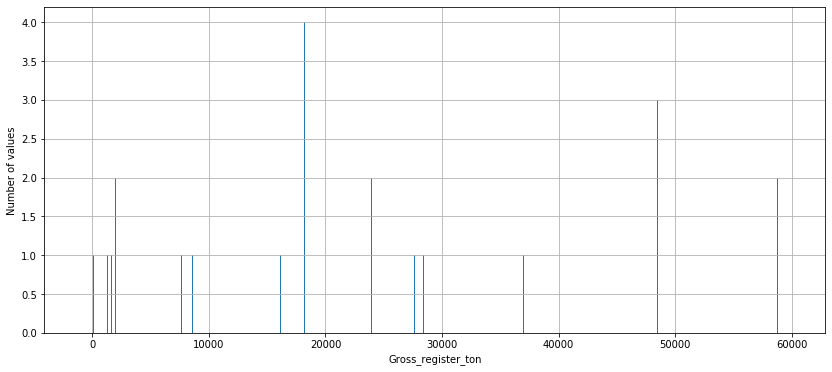

<Figure size 432x288 with 0 Axes>

In [38]:
property_overview("P1093","gross tonnage","quantity")

In [41]:
class_overview("Q154","Alcoholic_Beverages")

Label_,Pagerank,Link
Cahors wine,1.043620e-07,https://www.wikidata.org/wiki/Q1025792
Medovukha,1.043620e-07,https://www.wikidata.org/wiki/Q1051149
Gambina,1.043620e-07,https://www.wikidata.org/wiki/Q11860280


Property Name,Instances,% Instances
instance of,78,100.00
country of origin,35,44.87
image,35,44.87
subclass of,31,39.74
Freebase ID,29,37.18
Commons category,29,37.18
country,25,32.05
official website,22,28.21
TasteAtlas ID,20,25.64
inception,16,20.51


Property Name,Instances
product or material produced,10
material used,8
has part,6
owner of,5
subclass of,5
instance of,3
named after,2
main subject,2
depicts,2
subsidiary,2
